# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=None):
    # Retrieve stock data
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    # Define function to find best strategy for a given number of generation
    def _find_best_strategy(ngen: int) -> MonteCarloCrossValidation:
        optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
        print('Running genetic algorithm ...')
        hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3, cxpb=0.6)
        print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
        gbm = GeometricBrownianMotion(data)
        crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
        print('Running backtesting ...')
        crossvalidator.run(num_iterations=100, time_steps=252)
        return crossvalidator
    
    # Run grid search to find best number of generations
    if ngen is None:
        print('Trying to figure out optimal number of generations using grid search ...')
        best_ngen, best_cv_score, best_individual = 0, float('-inf'), None
        for ngen in range(1, 21):
            print(f'Iteration {ngen} of 20 with best cv score:', best_cv_score)
            res: MonteCarloCrossValidation = _find_best_strategy(ngen)
            if res.max_mean_net_profit > best_cv_score:
                best_ngen, best_cv_score, best_individual = ngen, res.max_mean_net_profit, res.best_individual
            print('--------------------')
        print(f'Result of grid search: ngen={best_ngen} with score {best_cv_score}')
        return best_individual
    # or take given number of generations
    else:
        res: MonteCarloCrossValidation = _find_best_strategy(ngen)
        return res.best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-85.6486	29.9755	-14.6639	17.7222
1  	731   	-79.2266	36.5246	-2.64436	13.2971
Net profit of buy and hold: 25.70609999999999
Running backtesting ...
Best individual: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Best average net profit: 2.327548244584816
--------------------
Iteration 2 of 20 with best cv score: 2.327548244584816
Running genetic algorithm ...


/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	min     	max    	mean    	std    
0  	1000  	-85.6486	29.9755	-14.6639	17.7222
1  	731   	-79.2266	36.5246	-2.64436	13.2971
2  	693   	-78.5342	36.5246	4.90793 	11.6303
Net profit of buy and hold: 25.70609999999999
Running backtesting ...
Best individual: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Best average net profit: 2.2118915122224347
--------------------
Iteration 3 of 20 with best cv score: 2.327548244584816
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-85.6486	29.9755	-14.6639	17.7222
1  	731   	-79.2266	36.5246	-2.64436	13.2971
2  	693   	-78.5342	36.5246	4.90793 	11.6303
3  	732   	-77.015 	35.6328	10.0322 	12.0501
Net profit of buy and hold: 25.70609999999999
Running backtesting ..

4  	728   	-79.9915	41.7055	14.4871 	11.8219
5  	736   	-48.0689	37.5867	17.1292 	12.5254
6  	732   	-39.0632	41.9002	20.2133 	12.0093
7  	768   	-84.6671	40.7892	21.5938 	13.6005
8  	718   	-85.7964	42.5316	22.8456 	13.8256
9  	701   	-83.8447	44.0422	24.6936 	14.1494
10 	732   	-81.793 	44.8596	25.413  	14.4506
11 	724   	-81.0269	44.0422	26.721  	14.6856
Net profit of buy and hold: 25.70609999999999
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Best average net profit: 2.6627269647311937
--------------------
Iteration 12 of 20 with best cv score: 2.6841919763001147
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-85.6486	29.9755	-14.6639	17.7222
1  	731   	-79.2266	3

gen	nevals	min     	max    	mean    	std    
0  	1000  	-85.6486	29.9755	-14.6639	17.7222
1  	731   	-79.2266	36.5246	-2.64436	13.2971
2  	693   	-78.5342	36.5246	4.90793 	11.6303
3  	732   	-77.015 	35.6328	10.0322 	12.0501
4  	728   	-79.9915	41.7055	14.4871 	11.8219
5  	736   	-48.0689	37.5867	17.1292 	12.5254
6  	732   	-39.0632	41.9002	20.2133 	12.0093
7  	768   	-84.6671	40.7892	21.5938 	13.6005
8  	718   	-85.7964	42.5316	22.8456 	13.8256
9  	701   	-83.8447	44.0422	24.6936 	14.1494
10 	732   	-81.793 	44.8596	25.413  	14.4506
11 	724   	-81.0269	44.0422	26.721  	14.6856
12 	702   	-80.9287	45.4156	28.1613 	14.8745
13 	697   	-81.6175	47.1314	28.4645 	16.315 
14 	728   	-85.9897	47.1314	29.4014 	16.2489
15 	722   	-81.2384	47.1314	29.5689 	16.891 
16 	691   	-76.7889	47.1784	31.7701 	14.8059
17 	734   	-79.9915	53.5107	30.908  	17.706 
18 	685   	-81.2384	53.5107	31.5105 	16.8645
Net profit of buy and hold: 25.70609999999999
Running backtesting ...
Best individual: [0, 0, 1, 0, 

In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2018-01-01', end='2018-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[249], [186, 255], [37, 45, 111], [121], [34, 5]]
Net profit of strategy: -5.879300
Net profit of buy and hold: -21.006450
Percentage profit of strategy: -5.271024%
Percentage profit of buy and hold: -18.833109%
Number of buy signals: 11
Number of sell signals: 11


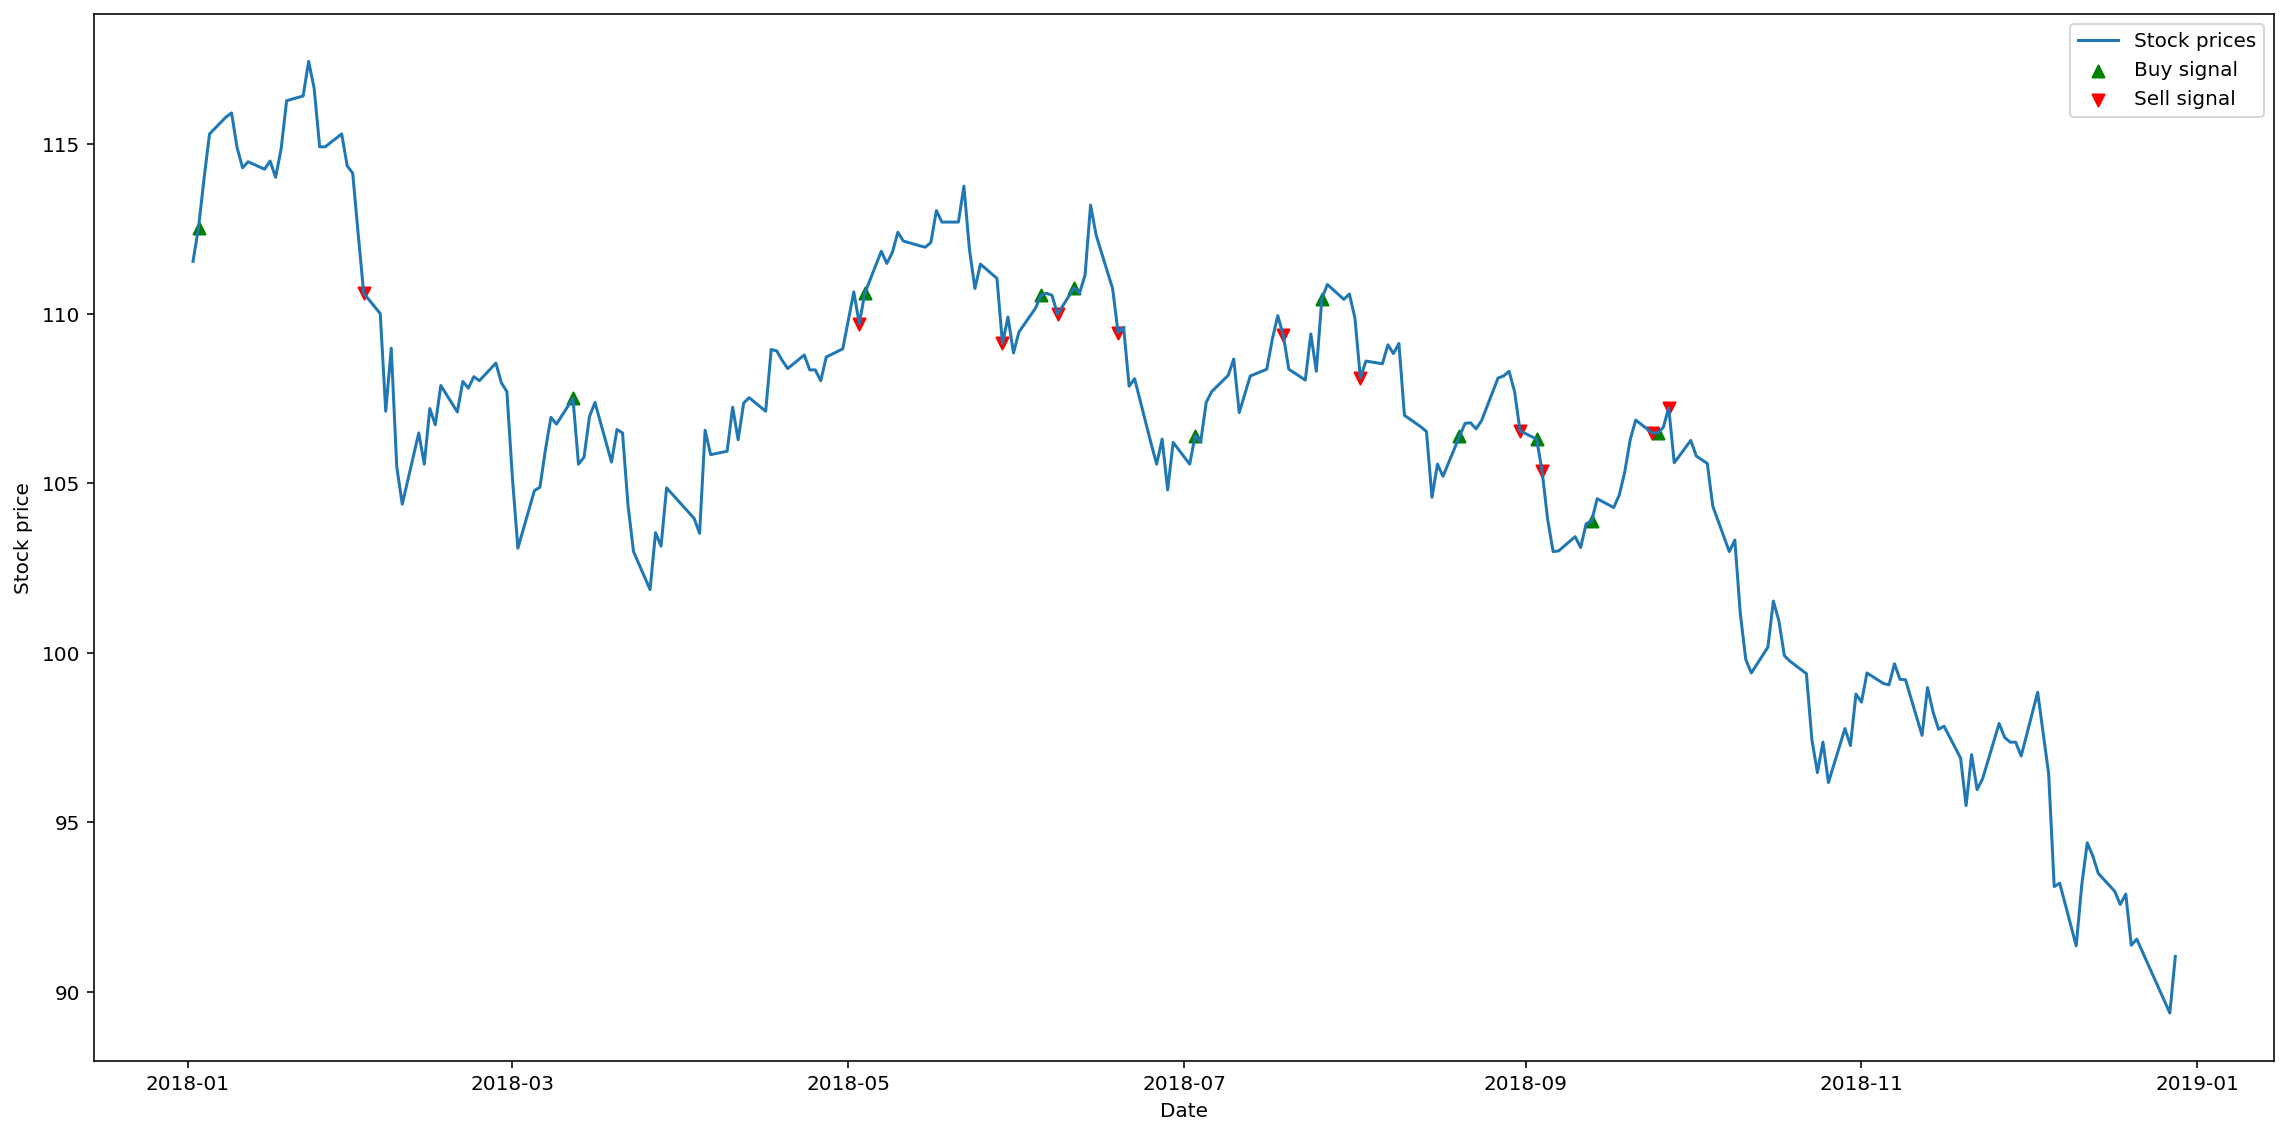

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2018-01-01', end='2018-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-43.8531	117.17	41.6665	31.8626
1  	731   	-31.4715	117.17	61.7781	25.3769
Net profit of buy and hold: 106.0601
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Best average net profit: 32.807481319386426
--------------------
Iteration 2 of 20 with best cv score: 32.807481319386426
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-43.8531	117.17	41.6665	31.8626
1  	731   	-31.4715	117.17	61.7781	25.3769
2  	693   	-25.6521	117.17	76.727 	22.3604
Net profit of buy and hold: 106.06

gen	nevals	min     	max   	mean   	std    
0  	1000  	-43.8531	117.17	41.6665	31.8626
1  	731   	-31.4715	117.17	61.7781	25.3769
2  	693   	-25.6521	117.17	76.727 	22.3604
3  	732   	-17.6605	122.838	83.2979	23.6273
4  	728   	-31.226 	125.166	90.0593	21.7918
5  	736   	-35.5968	126.474	92.9413	23.8245
6  	732   	-37.8652	134.869	97.1236	23.1704
7  	768   	-26.1659	134.869	99.6696	23.8915
8  	718   	-15.3377	134.869	102.156	24.1256
9  	701   	-17.8388	135.858	104.714	24.7683
10 	732   	-17.8388	133.257	105.833	25.9386
11 	724   	-17.8388	134.46 	108.195	25.2956
Net profit of buy and hold: 106.0601
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Best average net profit: 26.973844618502554
--------------------


gen	nevals	min     	max   	mean   	std    
0  	1000  	-43.8531	117.17	41.6665	31.8626
1  	731   	-31.4715	117.17	61.7781	25.3769
2  	693   	-25.6521	117.17	76.727 	22.3604
3  	732   	-17.6605	122.838	83.2979	23.6273
4  	728   	-31.226 	125.166	90.0593	21.7918
5  	736   	-35.5968	126.474	92.9413	23.8245
6  	732   	-37.8652	134.869	97.1236	23.1704
7  	768   	-26.1659	134.869	99.6696	23.8915
8  	718   	-15.3377	134.869	102.156	24.1256
9  	701   	-17.8388	135.858	104.714	24.7683
10 	732   	-17.8388	133.257	105.833	25.9386
11 	724   	-17.8388	134.46 	108.195	25.2956
12 	702   	-34.3146	136.914	110.978	23.8153
13 	697   	-36.0285	136.914	110.76 	27.3725
14 	728   	-19.9561	138.428	114.36 	24.4823
15 	722   	-18.4537	138.428	116.029	24.7717
16 	691   	-18.7865	138.428	119.073	23.0576
17 	734   	-18.4537	138.428	119.378	25.1623
18 	685   	-20.7979	138.428	120.236	25.5856
Net profit of buy and hold: 106.0601
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 

In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2018-01-01', end='2018-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[51, 1, 7], [109, 53, 74], [53, 7]]
Net profit of strategy: 10.215200
Net profit of buy and hold: 18.305800
Percentage profit of strategy: 6.495327%
Percentage profit of buy and hold: 11.639728%
Number of buy signals: 5
Number of sell signals: 5


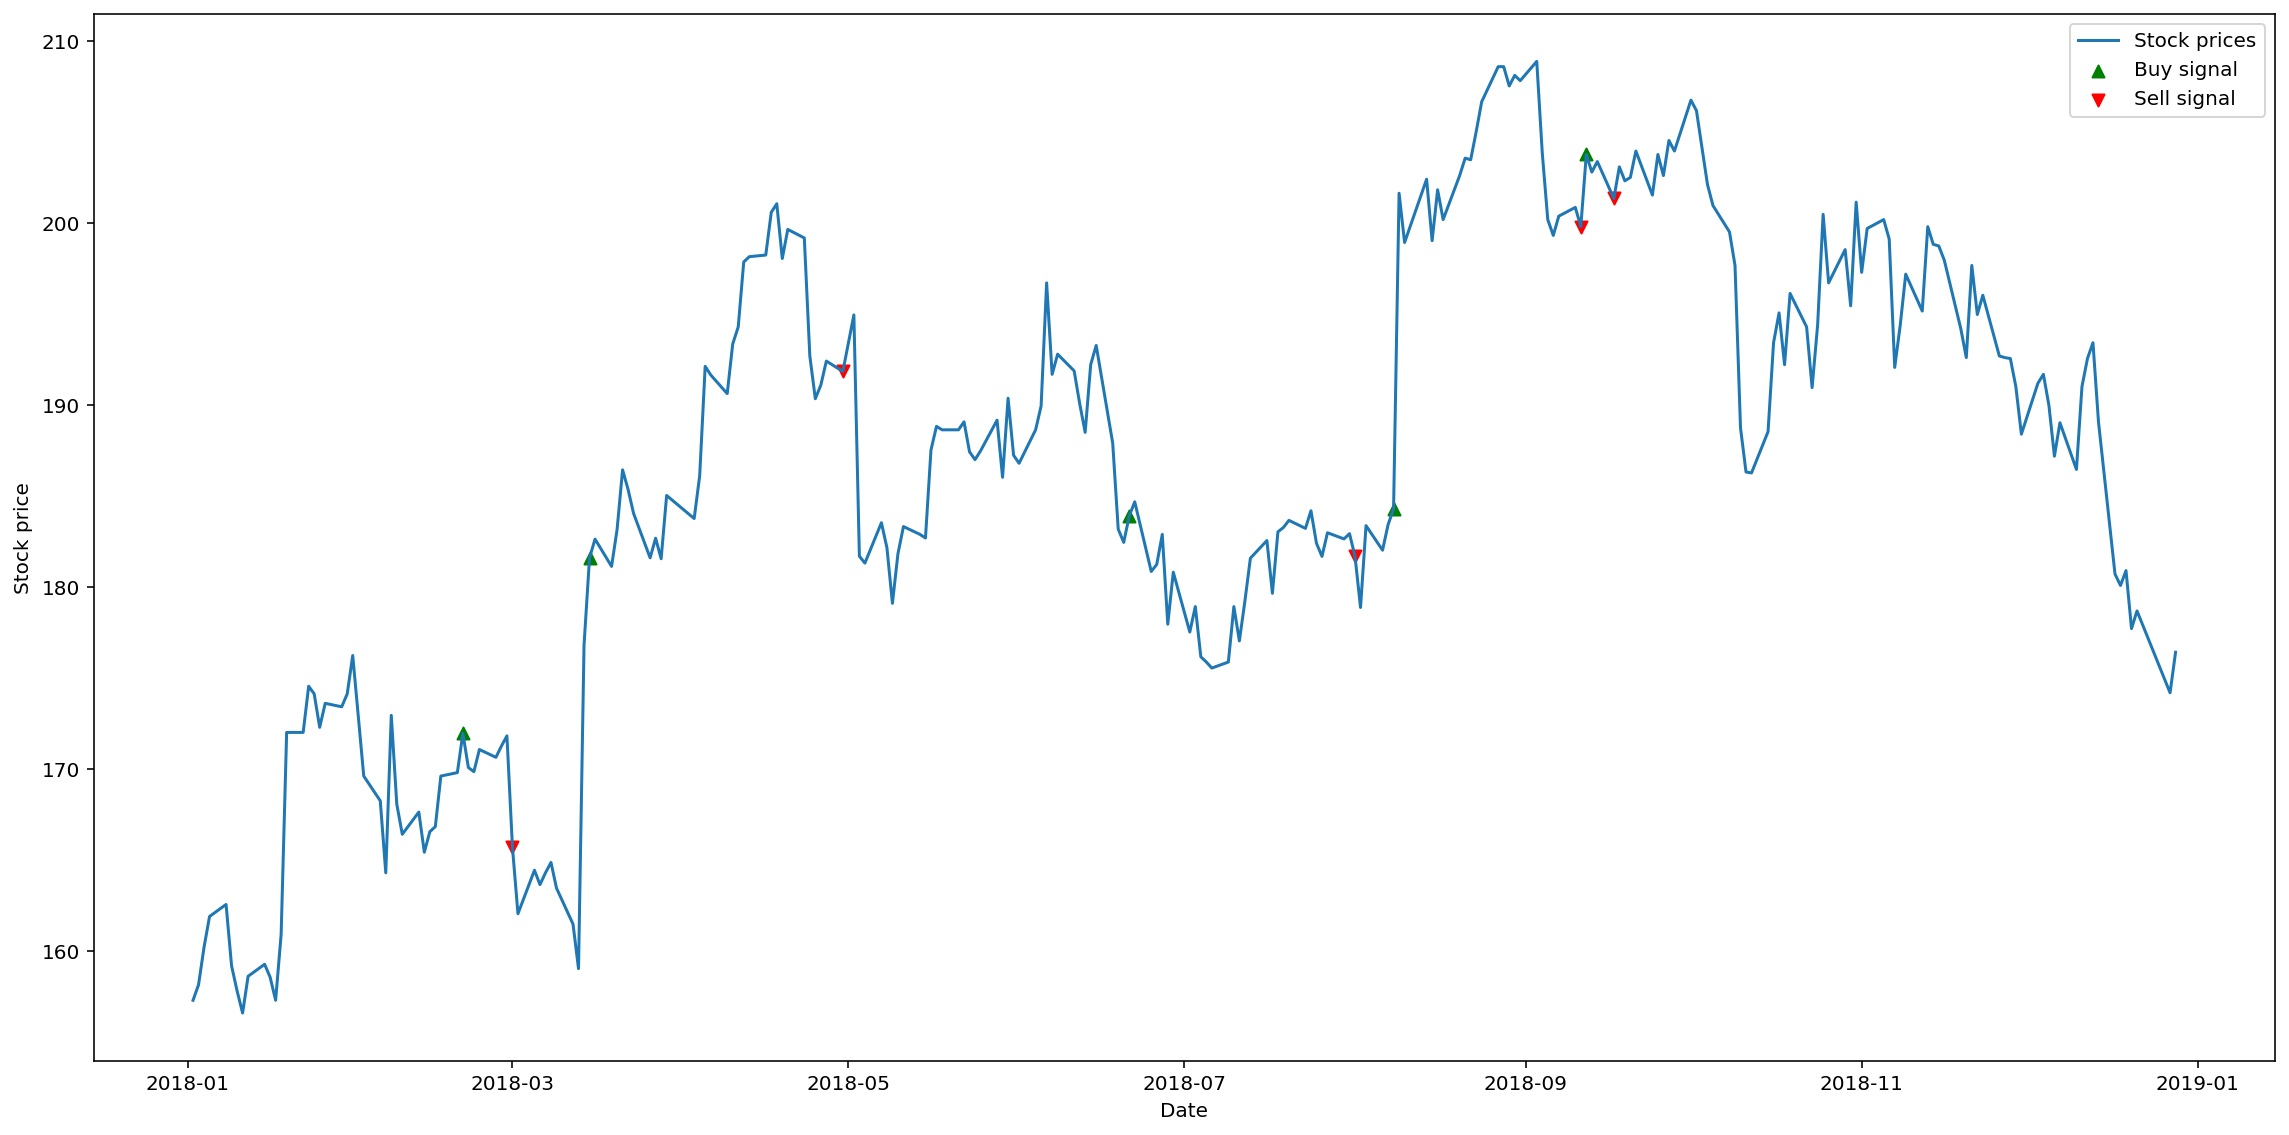

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2018-01-01', end='2018-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max   	mean     	std   
0  	1000  	-92.6392	51.815	-0.761633	23.097
1  	731   	-84.0175	60.9396	13.5845  	19.1724
Net profit of buy and hold: 67.40310000000001
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 10.542198451848401
--------------------
Iteration 2 of 20 with best cv score: 10.542198451848401
Running genetic algorithm ...
gen	nevals	min     	max   	mean     	std   
0  	1000  	-92.6392	51.815	-0.761633	23.097
1  	731   	-84.0175	60.9396	13.5845  	19.1724
2  	693   	-80.3048	60.7604	22.3349  	17.9955
Net profit o

9  	701   	-77.2043	78.3916	46.2429  	19.7015
10 	732   	-58.0559	78.3916	49.4931  	18.3736
Net profit of buy and hold: 67.40310000000001
Running backtesting ...
Best individual: [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
Best average net profit: 9.13598200074128
--------------------
Iteration 11 of 20 with best cv score: 14.144947037055331
Running genetic algorithm ...
gen	nevals	min     	max   	mean     	std   
0  	1000  	-92.6392	51.815	-0.761633	23.097
1  	731   	-84.0175	60.9396	13.5845  	19.1724
2  	693   	-80.3048	60.7604	22.3349  	17.9955
3  	732   	-84.1114	66.1578	26.419   	18.7001
4  	728   	-83.3479	60.7604	31.3761  	19.2284
5  	736   	-72.8873	66.7272	34.2904  	20.0227
6  	732   	-65.8991	70.7282	38.0786  	19.8456
7  	768   	-83.07

3  	732   	-84.1114	66.1578	26.419   	18.7001
4  	728   	-83.3479	60.7604	31.3761  	19.2284
5  	736   	-72.8873	66.7272	34.2904  	20.0227
6  	732   	-65.8991	70.7282	38.0786  	19.8456
7  	768   	-83.0757	78.3916	40.4657  	19.8368
8  	718   	-44.88  	78.3916	43.5751  	18.9943
9  	701   	-77.2043	78.3916	46.2429  	19.7015
10 	732   	-58.0559	78.3916	49.4931  	18.3736
11 	724   	-38.6622	78.3916	51.3552  	18.246 
12 	702   	-83.1463	80.5854	53.4372  	19.5566
13 	697   	-70.6938	83.4044	55.0788  	19.1707
14 	728   	-63.8154	83.4044	56.896   	19.4097
15 	722   	-49.2921	83.4044	58.5534  	19.4036
16 	691   	-56.8941	90.9826	60.7457  	19.7226
17 	734   	-71.8582	90.9826	62.133   	20.6231
Net profit of buy and hold: 67.40310000000001
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 

In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2018-01-01', end='2018-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[52, 62, 7], [39, 60, 126], [53, 7]]
Net profit of strategy: -17.880675
Net profit of buy and hold: -9.630200
Percentage profit of strategy: -10.742370%
Percentage profit of buy and hold: -5.785641%
Number of buy signals: 5
Number of sell signals: 5


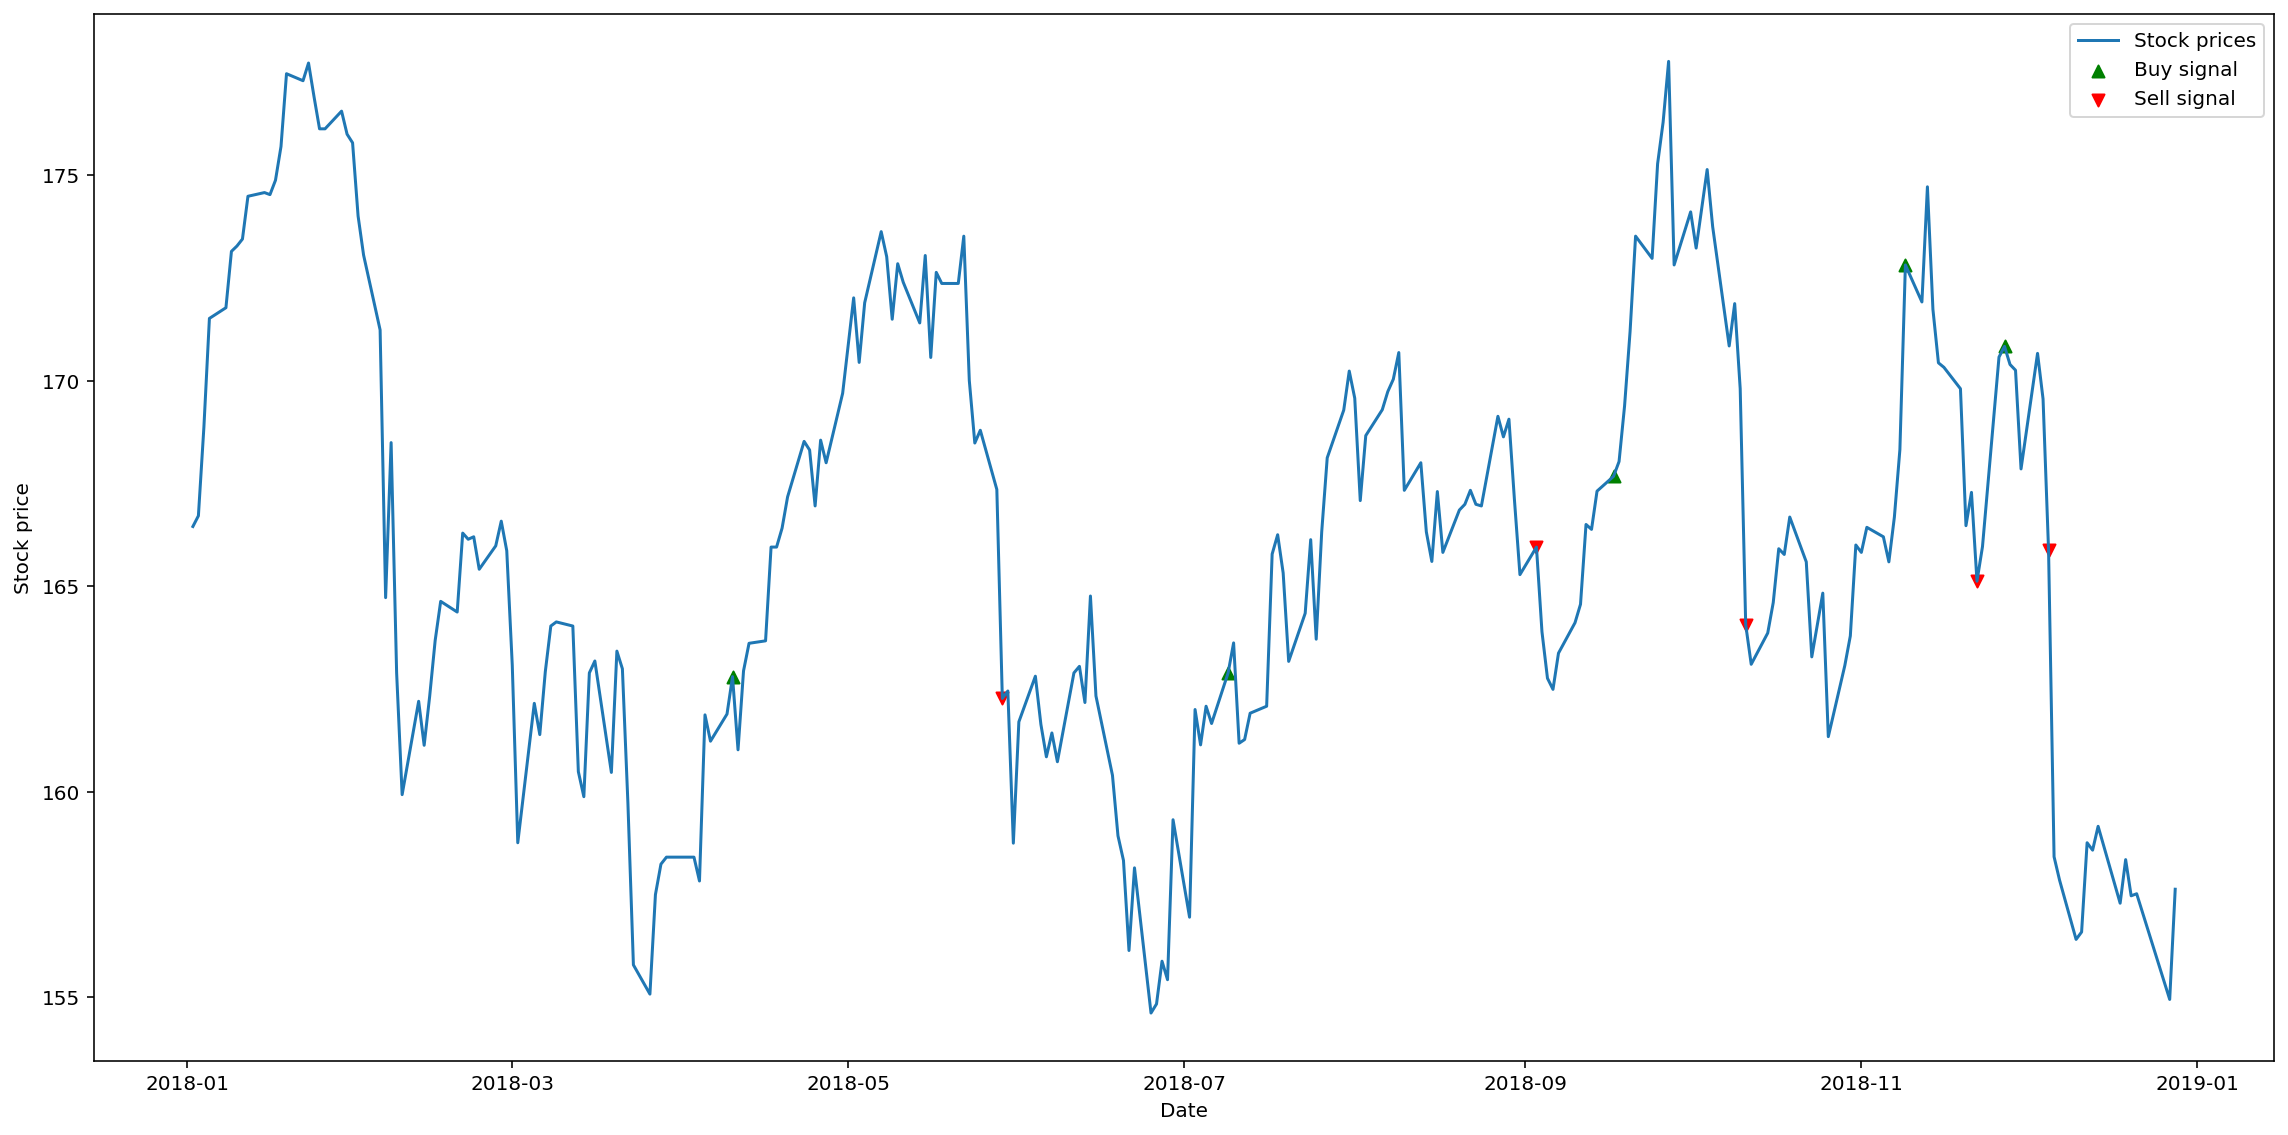

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2018-01-01', end='2018-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-43.3317	32.3565	-3.68319	13.7599
1  	731   	-44.5309	32.562 	5.65008 	10.1517
Net profit of buy and hold: 23.109549999999995
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 3.5322442739507123
--------------------
Iteration 2 of 20 with best cv score: 3.5322442739507123
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-43.3317	32.3565	-3.68319	13.7599
1  	731   	-44.5309	32.562 	5.65008 	10.1517
2  	693   	-44.8014	32.898 	10.9503 	9.41453
Net profit

10 	732   	-23.5451	45.0222	33.7529 	8.98594
Net profit of buy and hold: 23.109549999999995
Running backtesting ...
Best individual: [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Best average net profit: 3.007617679254321
--------------------
Iteration 11 of 20 with best cv score: 3.5322442739507123
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-43.3317	32.3565	-3.68319	13.7599
1  	731   	-44.5309	32.562 	5.65008 	10.1517
2  	693   	-44.8014	32.898 	10.9503 	9.41453
3  	732   	-40.6094	33.8143	14.4328 	10.1308
4  	728   	-35.4591	39.6146	18.7255 	9.95579
5  	736   	-37.6826	42.4281	22.3327 	10.4828
6  	732   	-35.51  	42.9448	26.0626 	9.41999
7  	768   	-28.4586	45.0222	28.0634 	9.74584
8  	718   	-34.9127	4

5  	736   	-37.6826	42.4281	22.3327 	10.4828
6  	732   	-35.51  	42.9448	26.0626 	9.41999
7  	768   	-28.4586	45.0222	28.0634 	9.74584
8  	718   	-34.9127	45.0222	29.9628 	9.63268
9  	701   	-36.4014	45.0222	32.4594 	9.053  
10 	732   	-23.5451	45.0222	33.7529 	8.98594
11 	724   	-34.9127	47.5074	35.1877 	9.94572
12 	702   	-35.2097	47.5074	36.6278 	9.16841
13 	697   	-30.7667	48.0192	36.8487 	10.7083
14 	728   	-36.9419	48.7195	37.9732 	9.64373
15 	722   	-27.5351	48.9715	37.6729 	10.3971
16 	691   	-24.8153	48.9715	38.7521 	9.75876
17 	734   	-33.5154	48.9715	38.9591 	10.9722
Net profit of buy and hold: 23.109549999999995
Running backtesting ...
Best individual: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Best average net profit: 3.31375311903

In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2018-01-01', end='2018-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[39, 230], [38, 36, 28], [32, 55, 8], [254], [4, 7]]
Net profit of strategy: -8.445625
Net profit of buy and hold: -23.369600
Percentage profit of strategy: -11.498468%
Percentage profit of buy and hold: -31.817018%
Number of buy signals: 4
Number of sell signals: 4


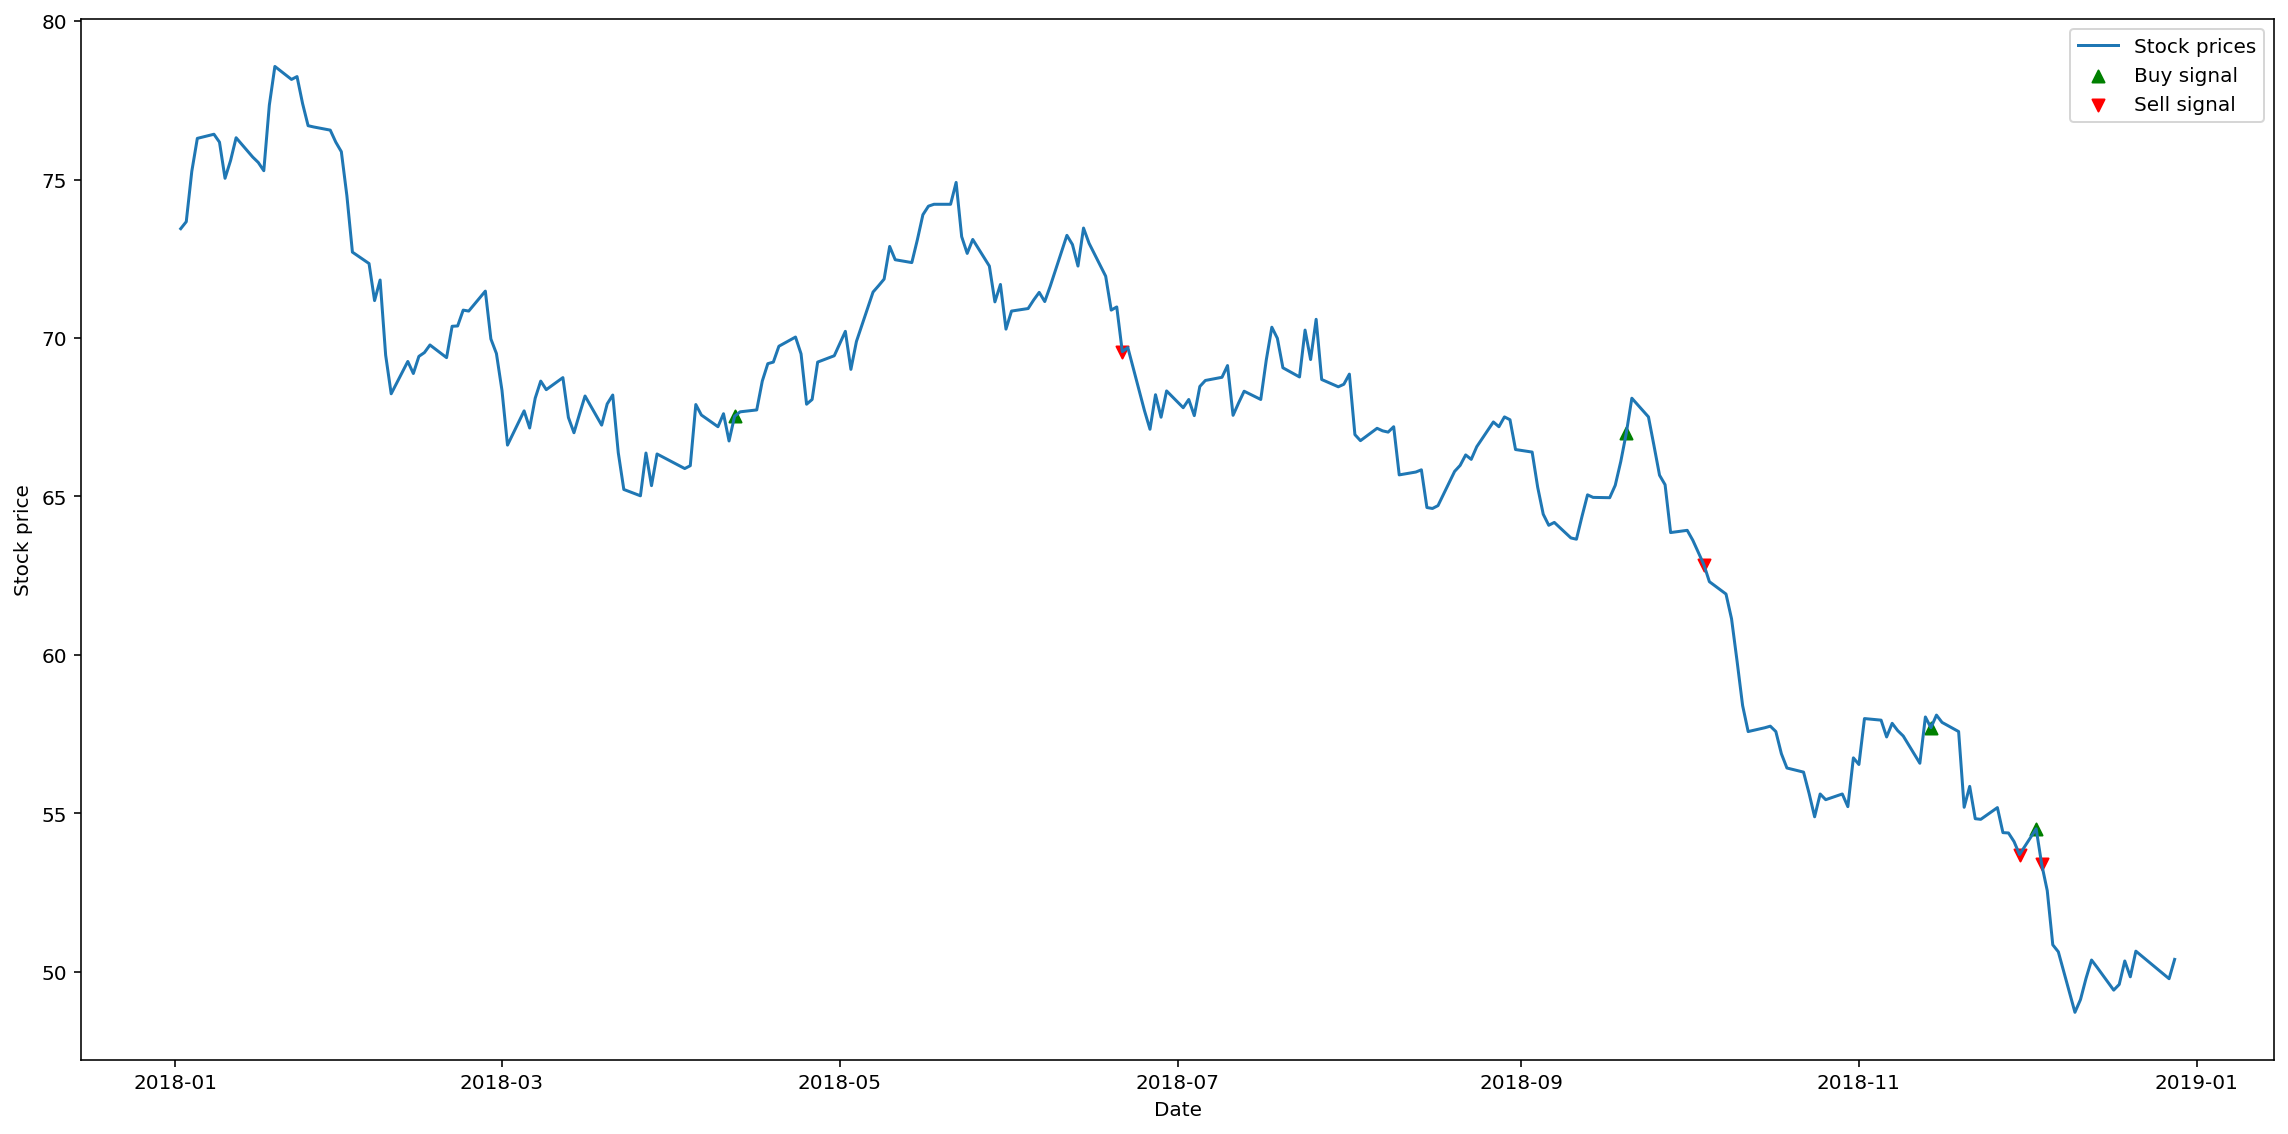

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2018-01-01', end='2018-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17.9725	7.58137	-3.40557	3.92631
1  	731   	-16.1444	9.28172	-0.988586	3.21886
Net profit of buy and hold: -5.711249999999999
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]
Best average net profit: -0.3069003514253739
--------------------
Iteration 2 of 20 with best cv score: -0.3069003514253739
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17.9725	7.58137	-3.40557	3.92631
1  	731   	-16.1444	9.28172	-0.988586	3.21886
2  	693   	-13.5815	10.0207	0.558994 	3.20202
Net p

8  	718   	-9.4238 	13.6257	6.40606  	3.24479
9  	701   	-6.77875	13.6257	7.09138  	3.26592
10 	732   	-10.2105	13.8053	7.42381  	3.48862
Net profit of buy and hold: -5.711249999999999
Running backtesting ...
Best individual: [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
Best average net profit: -0.7228515424966937
--------------------
Iteration 11 of 20 with best cv score: -0.3069003514253739
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17.9725	7.58137	-3.40557	3.92631
1  	731   	-16.1444	9.28172	-0.988586	3.21886
2  	693   	-13.5815	10.0207	0.558994 	3.20202
3  	732   	-9.35858	10.0207	1.87711  	3.14926
4  	728   	-16.9419	11.2141	2.9063   	3.35853
5  	736   	-13.591 	14.203 	3.95881  	3.49229
6  	732   

1  	731   	-16.1444	9.28172	-0.988586	3.21886
2  	693   	-13.5815	10.0207	0.558994 	3.20202
3  	732   	-9.35858	10.0207	1.87711  	3.14926
4  	728   	-16.9419	11.2141	2.9063   	3.35853
5  	736   	-13.591 	14.203 	3.95881  	3.49229
6  	732   	-8.9595 	14.203 	4.81005  	3.52035
7  	768   	-13.2857	14.203 	5.55533  	3.55802
8  	718   	-9.4238 	13.6257	6.40606  	3.24479
9  	701   	-6.77875	13.6257	7.09138  	3.26592
10 	732   	-10.2105	13.8053	7.42381  	3.48862
11 	724   	-8.00075	13.8053	7.78837  	3.61069
12 	702   	-10.4815	15.5534	8.41711  	3.65128
13 	697   	-6.41665	16.1534	8.75626  	3.53407
14 	728   	-11.1676	16.1791	9.01721  	3.78296
15 	722   	-13.0418	16.318 	9.10033  	4.19063
16 	691   	-13.5421	16.318 	10.1774  	3.75352
17 	734   	-9.00125	16.4897	10.5948  	3.86892
Net profit of buy and hold: -5.711249999999999
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2018-01-01', end='2018-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[174], [25, 5, 56], [61, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: -8.725925
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: -56.223744%
Number of buy signals: 0
Number of sell signals: 0


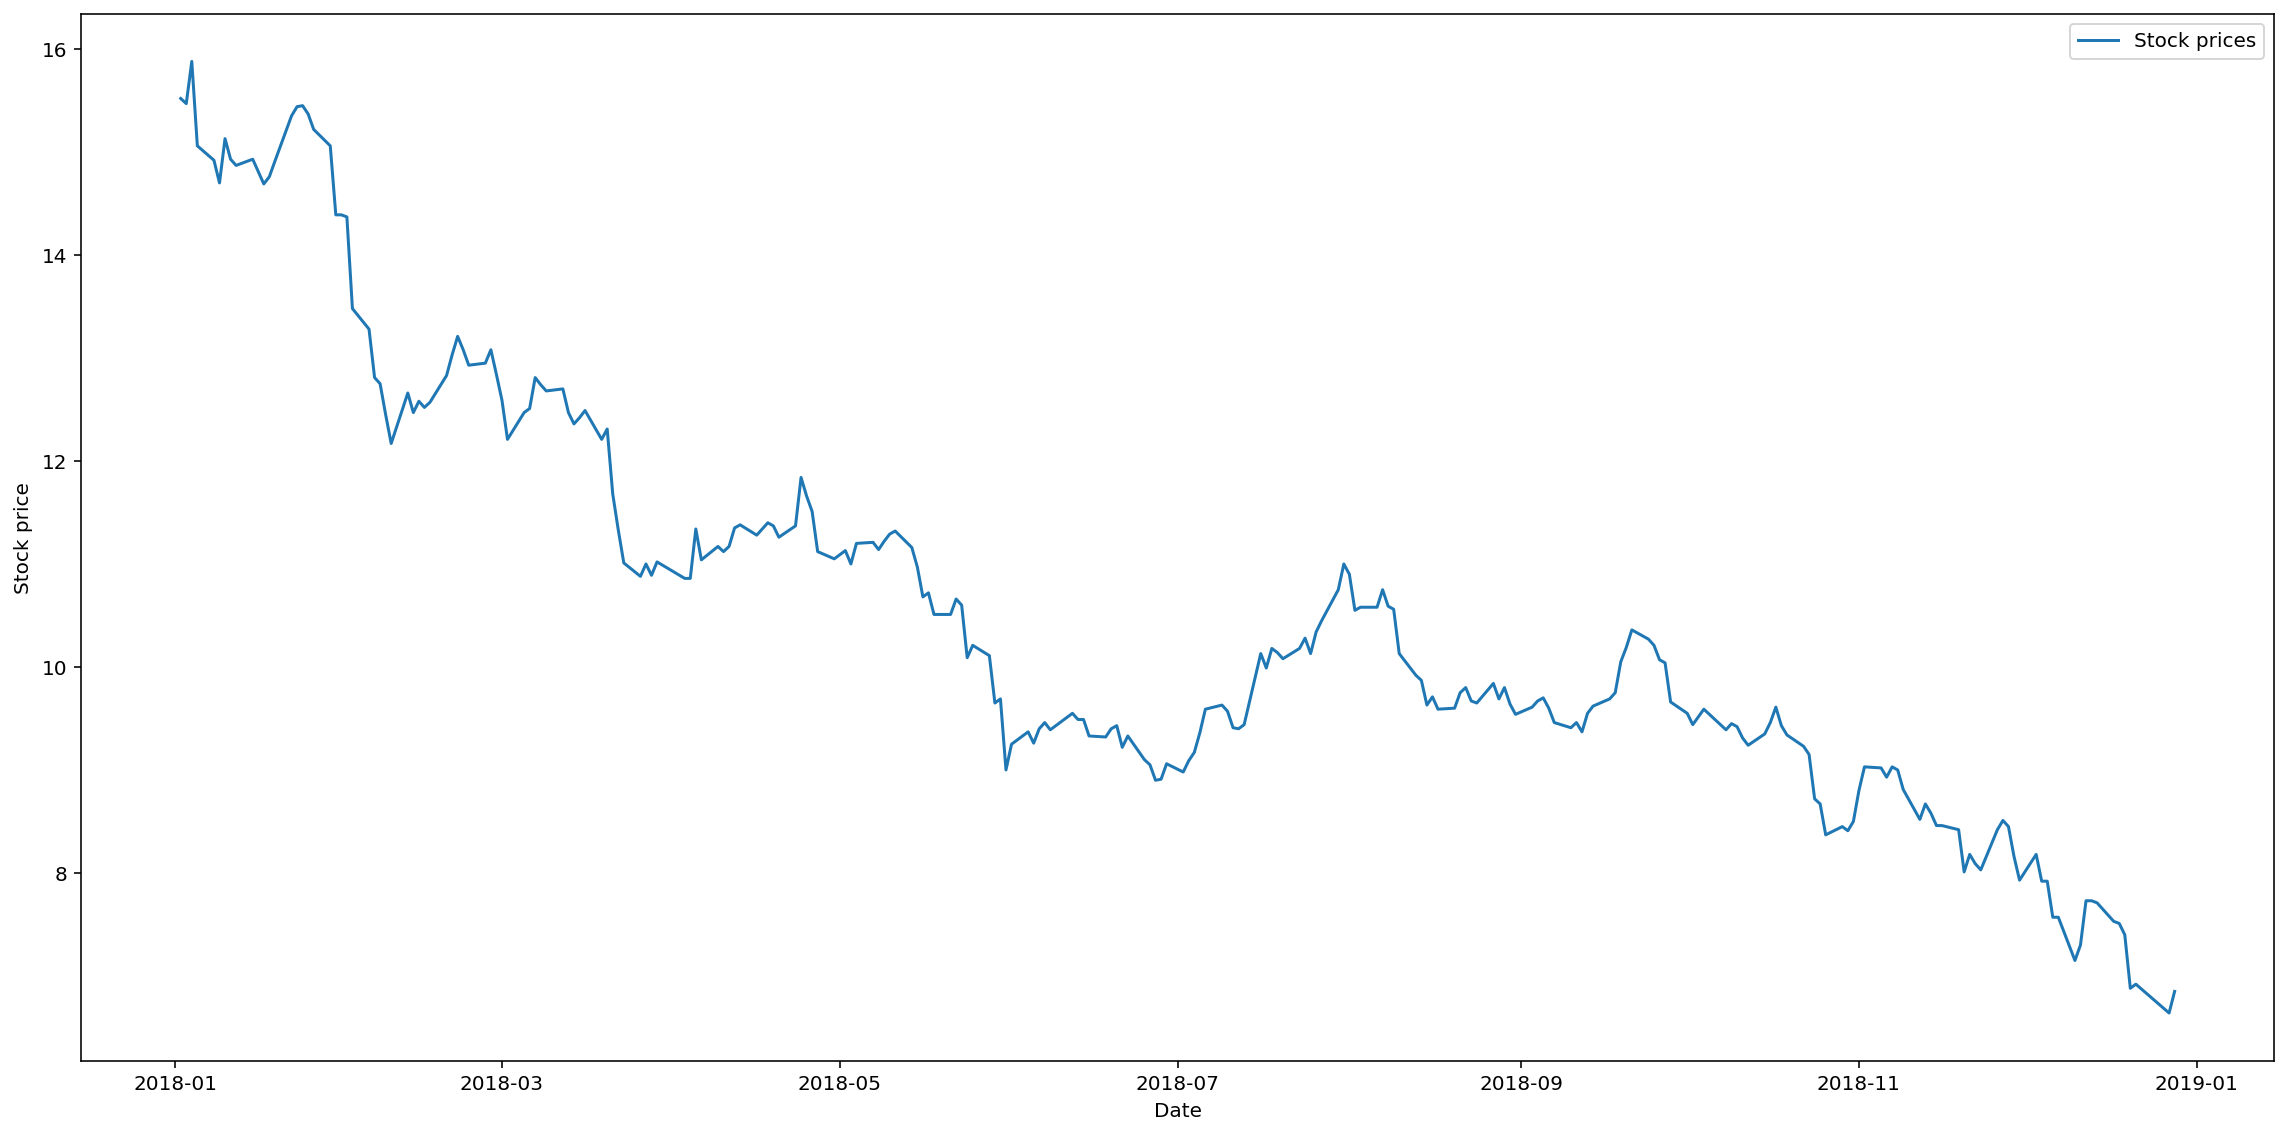

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2018-01-01', end='2018-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-10.0097	2.27863	-3.89662	2.19949
1  	731   	-9.1712 	2.4922 	-2.34687	1.83275
Net profit of buy and hold: 3.306900000000001
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Best average net profit: 0.31614439118088045
--------------------
Iteration 2 of 20 with best cv score: 0.31614439118088045
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-10.0097	2.27863	-3.89662	2.19949
1  	731   	-9.1712 	2.4922 	-2.34687	1.83275
2  	693   	-8.82107	4.935  	-1.41012	1.65657
Net profi

9  	701   	-9.51062	6.97975	1.71208  	2.35116
10 	732   	-9.8084 	7.678  	2.13981  	2.61036
Net profit of buy and hold: 3.306900000000001
Running backtesting ...
Best individual: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Best average net profit: 0.923797055812595
--------------------
Iteration 11 of 20 with best cv score: 1.0954243192547244
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-10.0097	2.27863	-3.89662	2.19949
1  	731   	-9.1712 	2.4922 	-2.34687	1.83275
2  	693   	-8.82107	4.935  	-1.41012	1.65657
3  	732   	-6.8664 	4.15387	-0.724862	1.49998
4  	728   	-9.5874 	5.09372	-0.285574	1.64985
5  	736   	-8.90388	5.09372	0.0490288	1.77242
6  	732   	-9.00438	5.61548	0.374789 	1.98969
7  	768   	-9.59

3  	732   	-6.8664 	4.15387	-0.724862	1.49998
4  	728   	-9.5874 	5.09372	-0.285574	1.64985
5  	736   	-8.90388	5.09372	0.0490288	1.77242
6  	732   	-9.00438	5.61548	0.374789 	1.98969
7  	768   	-9.59368	5.4701 	0.869937 	2.04085
8  	718   	-9.39698	6.89995	1.27811  	2.23017
9  	701   	-9.51062	6.97975	1.71208  	2.35116
10 	732   	-9.8084 	7.678  	2.13981  	2.61036
11 	724   	-9.57833	7.678  	2.56908  	2.63997
12 	702   	-10.0354	8.5996 	3.32107  	2.56307
13 	697   	-8.90388	8.5996 	3.69921  	2.72966
14 	728   	-10.5541	8.5996 	4.03194  	2.78115
15 	722   	-10.6538	9.09522	4.18287  	3.10635
16 	691   	-9.82158	9.09522	4.65182  	2.97303
17 	734   	-9.65827	9.92315	4.90262  	3.2246 
Net profit of buy and hold: 3.306900000000001
Running backtesting ...
Best individual: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 

In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2018-01-01', end='2018-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[3, 12, 94], [21, 4]]
Net profit of strategy: 0.699300
Net profit of buy and hold: 0.526875
Percentage profit of strategy: 5.671533%
Percentage profit of buy and hold: 4.273114%
Number of buy signals: 3
Number of sell signals: 3


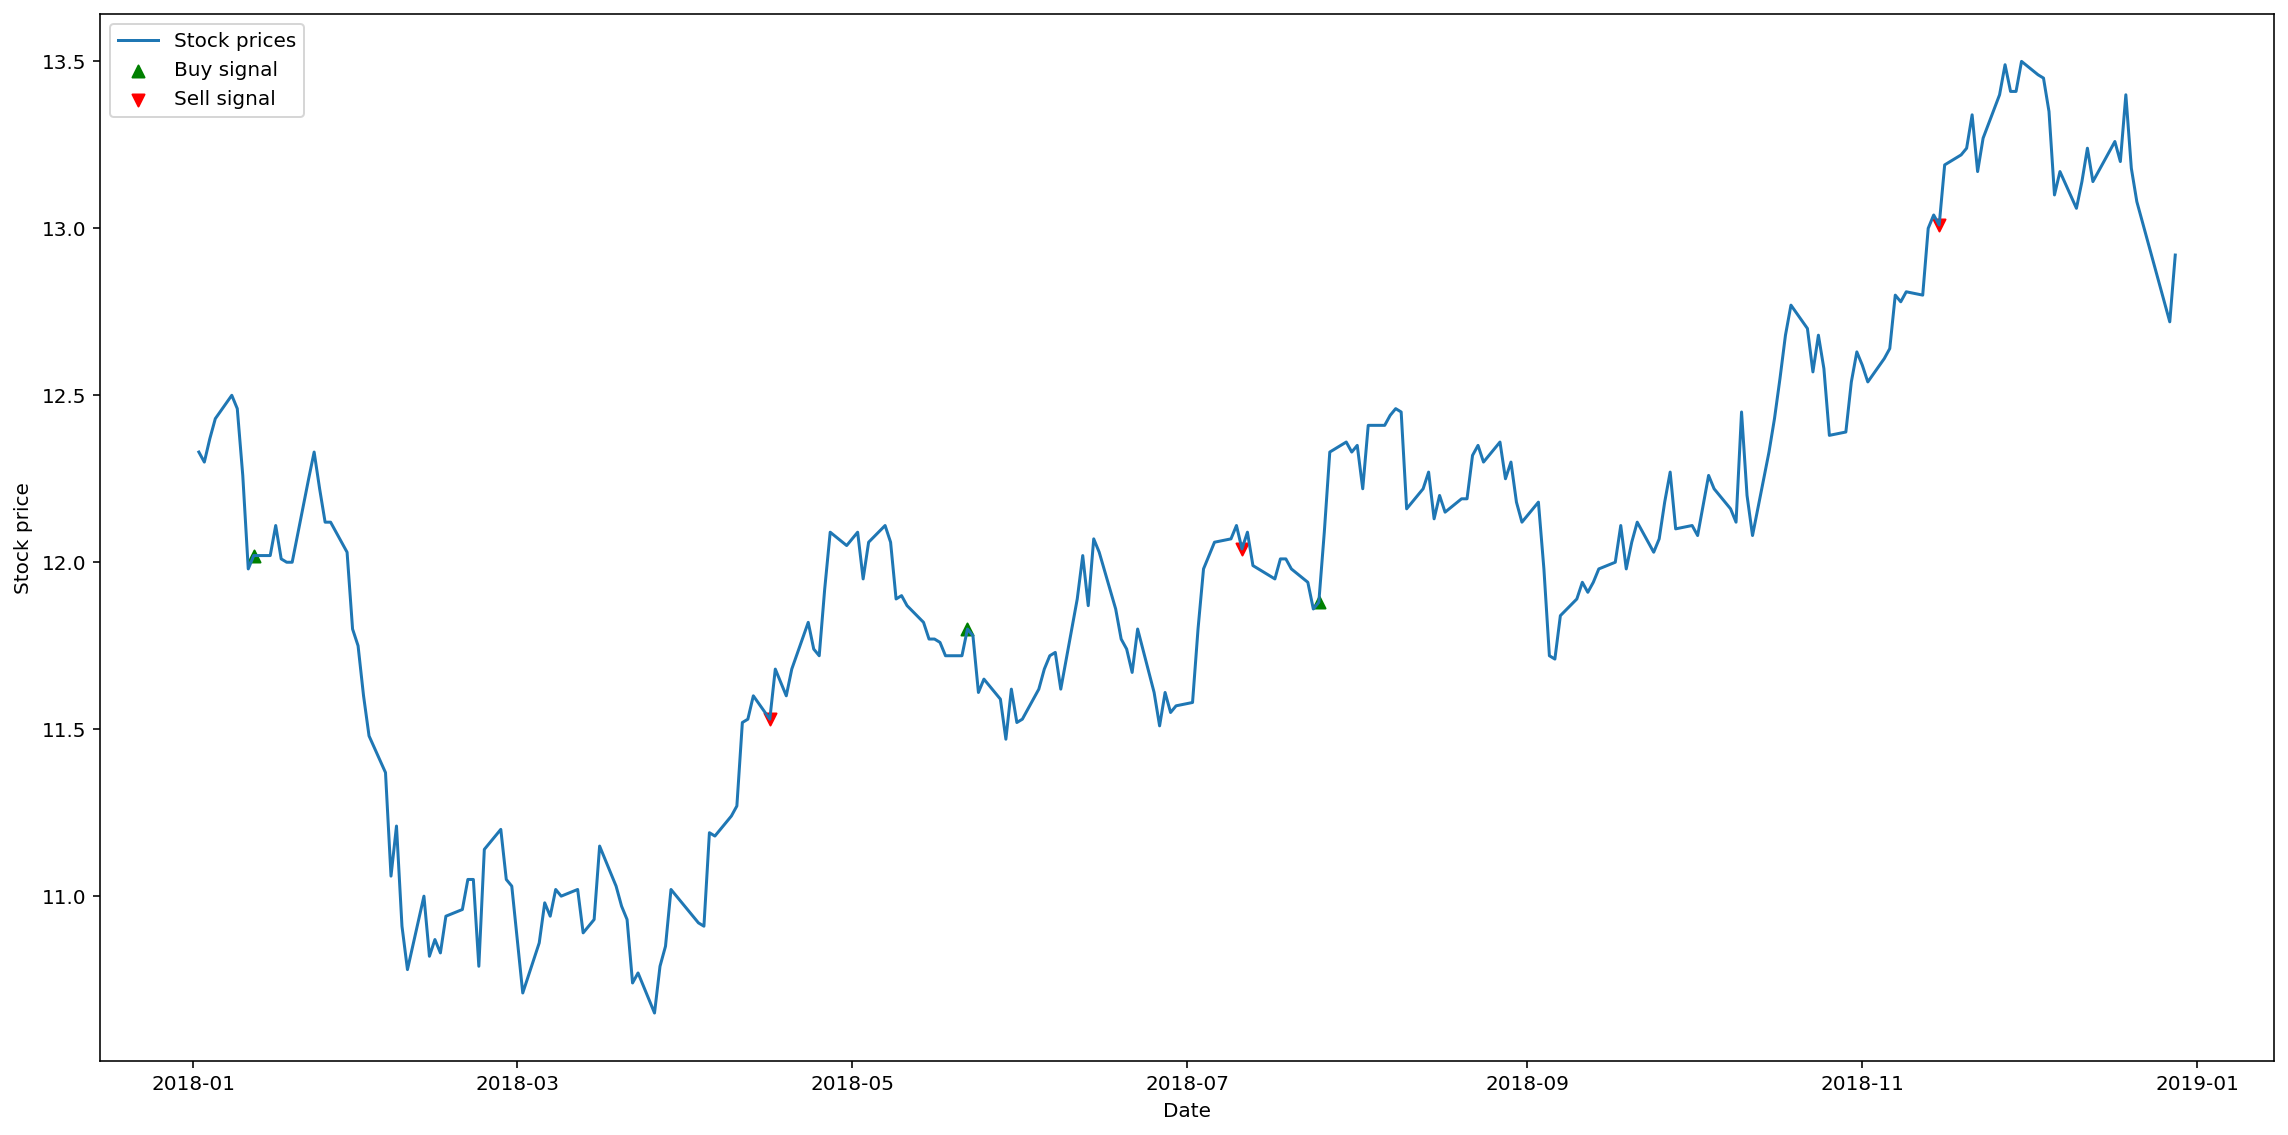

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2018-01-01', end='2018-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-49.6147	40.7233	0.914706	14.8061
1  	731   	-45.2016	41.2692	11.2655 	11.54  
Net profit of buy and hold: 35.36805
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Best average net profit: 5.495883890126116
--------------------
Iteration 2 of 20 with best cv score: 5.495883890126116
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-49.6147	40.7233	0.914706	14.8061
1  	731   	-45.2016	41.2692	11.2655 	11.54  
2  	693   	-45.3812	42.1466	17.6026 	11.0265
Net profit of buy and 

Best individual: [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Best average net profit: 3.9359894302139535
--------------------
Iteration 11 of 20 with best cv score: 9.134472729168538
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-49.6147	40.7233	0.914706	14.8061
1  	731   	-45.2016	41.2692	11.2655 	11.54  
2  	693   	-45.3812	42.1466	17.6026 	11.0265
3  	732   	-45.2016	45.555 	21.5742 	12.1459
4  	728   	-31.7222	45.555 	26.1839 	10.632 
5  	736   	-44.0862	48.2177	29.3554 	10.4988
6  	732   	-44.3587	49.537 	32.1416 	10.766 
7  	768   	-29.8602	50.4726	34.4581 	10.4231
8  	718   	-18.9149	50.8024	36.7646 	9.87043
9  	701   	-20.9552	53.6306	39.3467 	9.00649
10 	732   	-45.2016	53.6306	41.0053 	9.35284
11

9  	701   	-20.9552	53.6306	39.3467 	9.00649
10 	732   	-45.2016	53.6306	41.0053 	9.35284
11 	724   	-29.791 	55.1286	42.1807 	10.0205
12 	702   	-17.5251	55.1286	43.8016 	9.8867 
13 	697   	-10.3052	55.1286	44.5583 	10.2016
14 	728   	-40.6744	56.1141	45.5719 	10.3263
15 	722   	-41.5714	56.1141	45.5732 	11.9643
16 	691   	-25.2014	56.1141	47.2659 	10.5877
17 	734   	-44.3113	56.8849	47.6601 	10.9449
Net profit of buy and hold: 35.36805
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Best average net profit: 3.344122540224549
--------------------
Iteration 18 of 20 with best cv score: 9.134472729168538
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-49.6147	40.7233	0.91

In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2018-01-01', end='2018-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[60, 58, 62], [5, 113, 94], [125], [16, 4]]
Net profit of strategy: 3.273725
Net profit of buy and hold: -4.777325
Percentage profit of strategy: 3.735423%
Percentage profit of buy and hold: -5.451078%
Number of buy signals: 4
Number of sell signals: 4


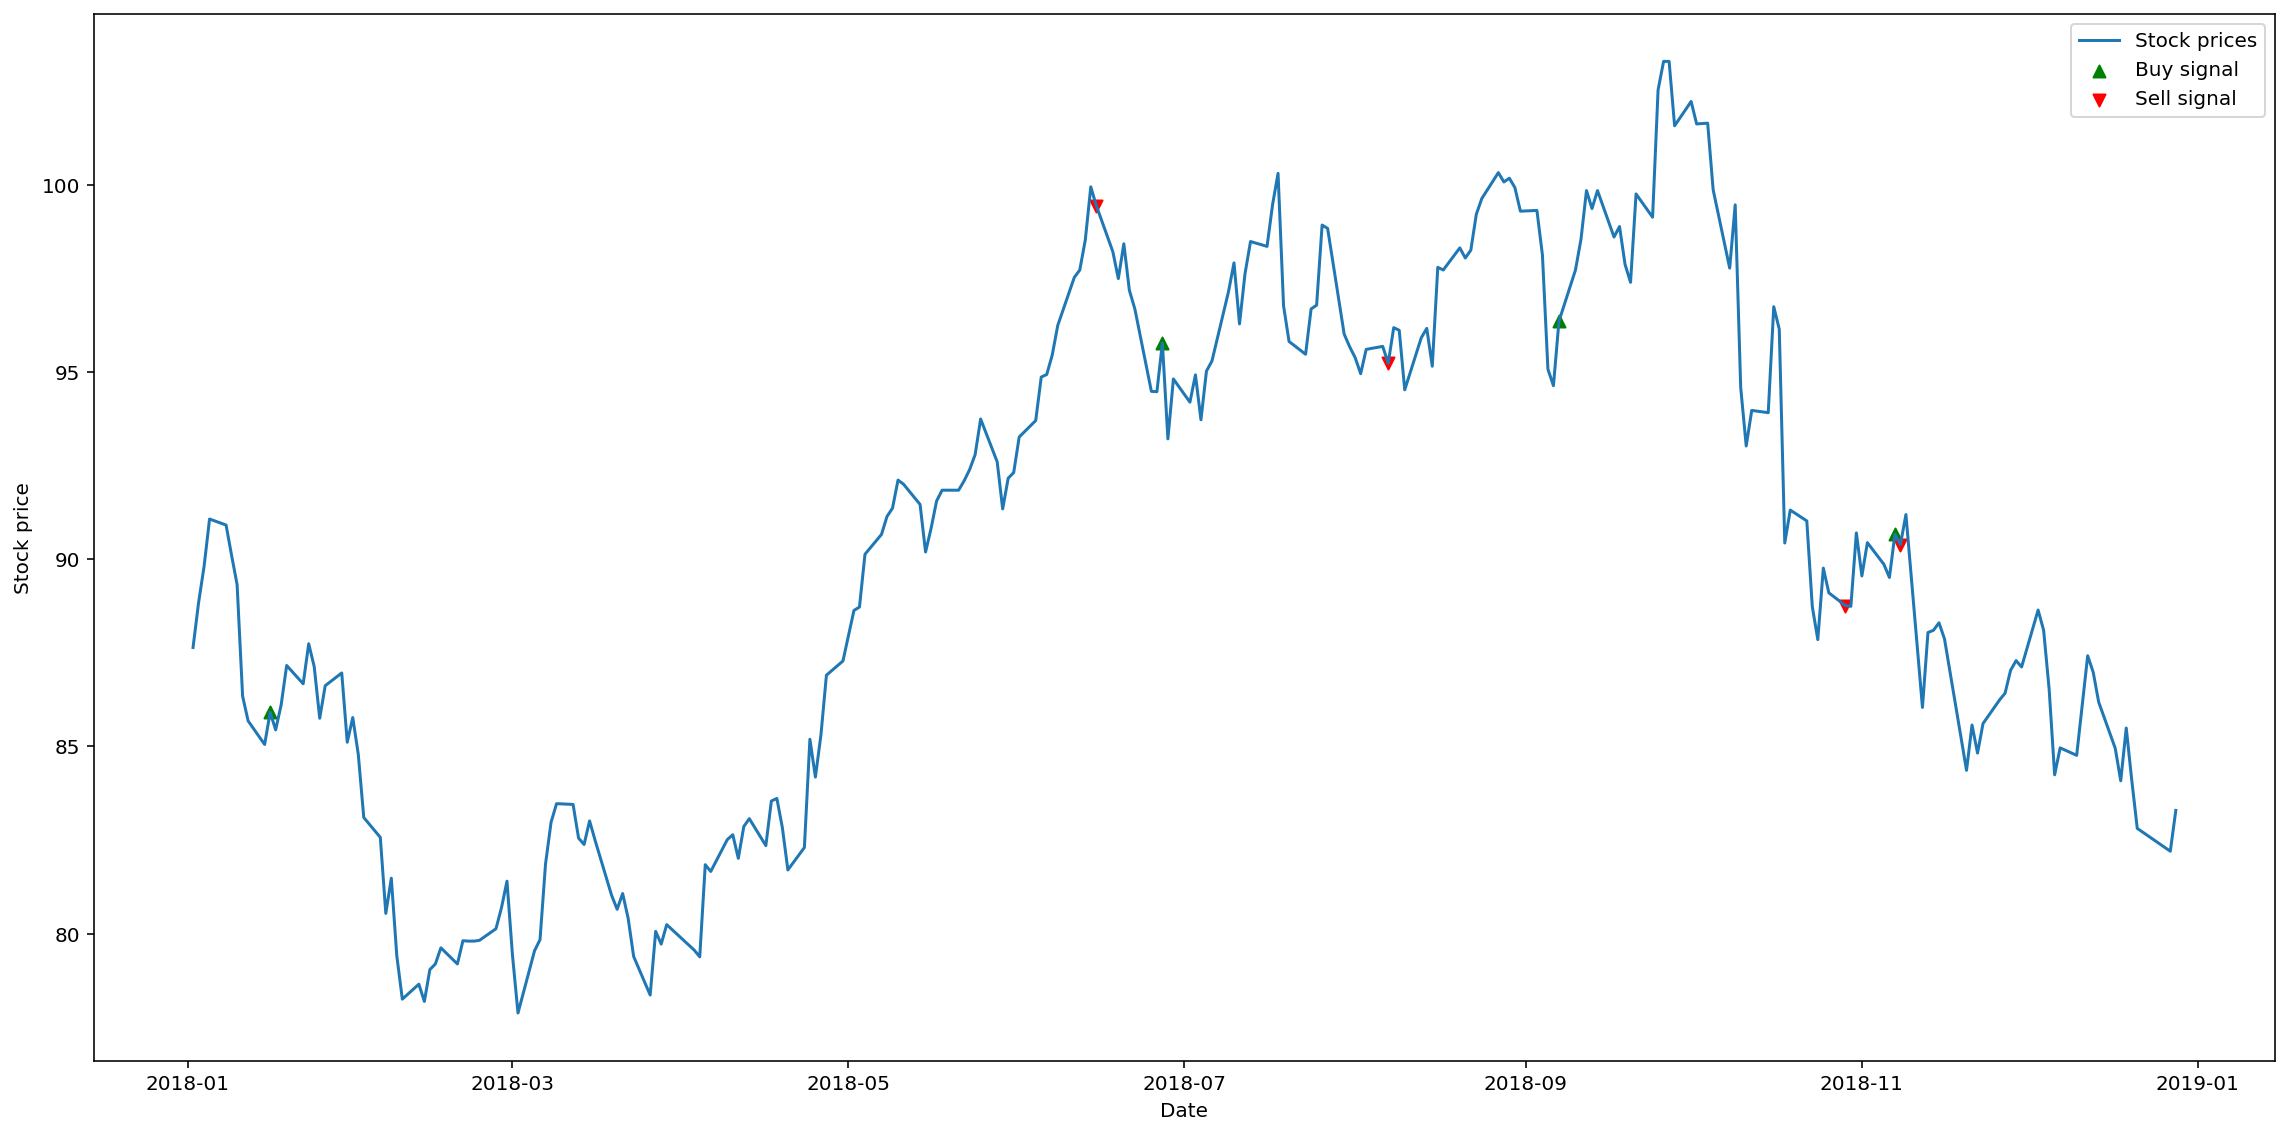

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2018-01-01', end='2018-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-18892.5	4984.57	-2576.51	3297.68
1  	731   	-18079.8	5541.44	-401.476	2418.41
Net profit of buy and hold: 6779.8195000000005
Running backtesting ...
Best individual: [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Best average net profit: 823.0475082795404
--------------------
Iteration 2 of 20 with best cv score: 823.0475082795404
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-18892.5	4984.57	-2576.51	3297.68
1  	731   	-18079.8	5541.44	-401.476	2418.41
2  	693   	-16537.7	4984.57	949.991 	1918.19
Net profit o

10 	732   	-16238.8	7844.81	3320.79 	2512.93
Net profit of buy and hold: 6779.8195000000005
Running backtesting ...
Best individual: [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1]
Best average net profit: 331.126493800644
--------------------
Iteration 11 of 20 with best cv score: 1061.6888607863264
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-18892.5	4984.57	-2576.51	3297.68
1  	731   	-18079.8	5541.44	-401.476	2418.41
2  	693   	-16537.7	4984.57	949.991 	1918.19
3  	732   	-12444.7	5289.11	1764.4  	1817.33
4  	728   	-18376.2	6572.78	2108.34 	2161.14
5  	736   	-16238.8	6572.78	2415.74 	2070   
6  	732   	-10238.2	6572.78	2661.86 	2025.93
7  	768   	-16020.4	7844.81	2848.72 	2256.15
8  	718   	-17967.5	78

5  	736   	-16238.8	6572.78	2415.74 	2070   
6  	732   	-10238.2	6572.78	2661.86 	2025.93
7  	768   	-16020.4	7844.81	2848.72 	2256.15
8  	718   	-17967.5	7844.81	2981.52 	2466.57
9  	701   	-10655.4	7844.81	3335.97 	2132.71
10 	732   	-16238.8	7844.81	3320.79 	2512.93
11 	724   	-16238.8	7844.81	3253.98 	2860.66
12 	702   	-17961.7	8121.21	3592.59 	2547.2 
13 	697   	-18131.8	8366.6 	3877.1  	2769.5 
14 	728   	-18280.6	8366.6 	4259.56 	2899.2 
15 	722   	-16400  	8366.6 	4954.45 	3134.27
16 	691   	-6930.27	8366.6 	5945.77 	2851.25
17 	734   	-16758.1	8773.51	6425.21 	3175.58
Net profit of buy and hold: 6779.8195000000005
Running backtesting ...
Best individual: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]
Best average net profit: 114.667724429

In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2018-01-01', end='2018-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[239], [21, 41, 23], [32, 59, 79], [35, 4]]
Net profit of strategy: -1546.036500
Net profit of buy and hold: -1881.316000
Percentage profit of strategy: -6.227991%
Percentage profit of buy and hold: -7.578617%
Number of buy signals: 4
Number of sell signals: 4


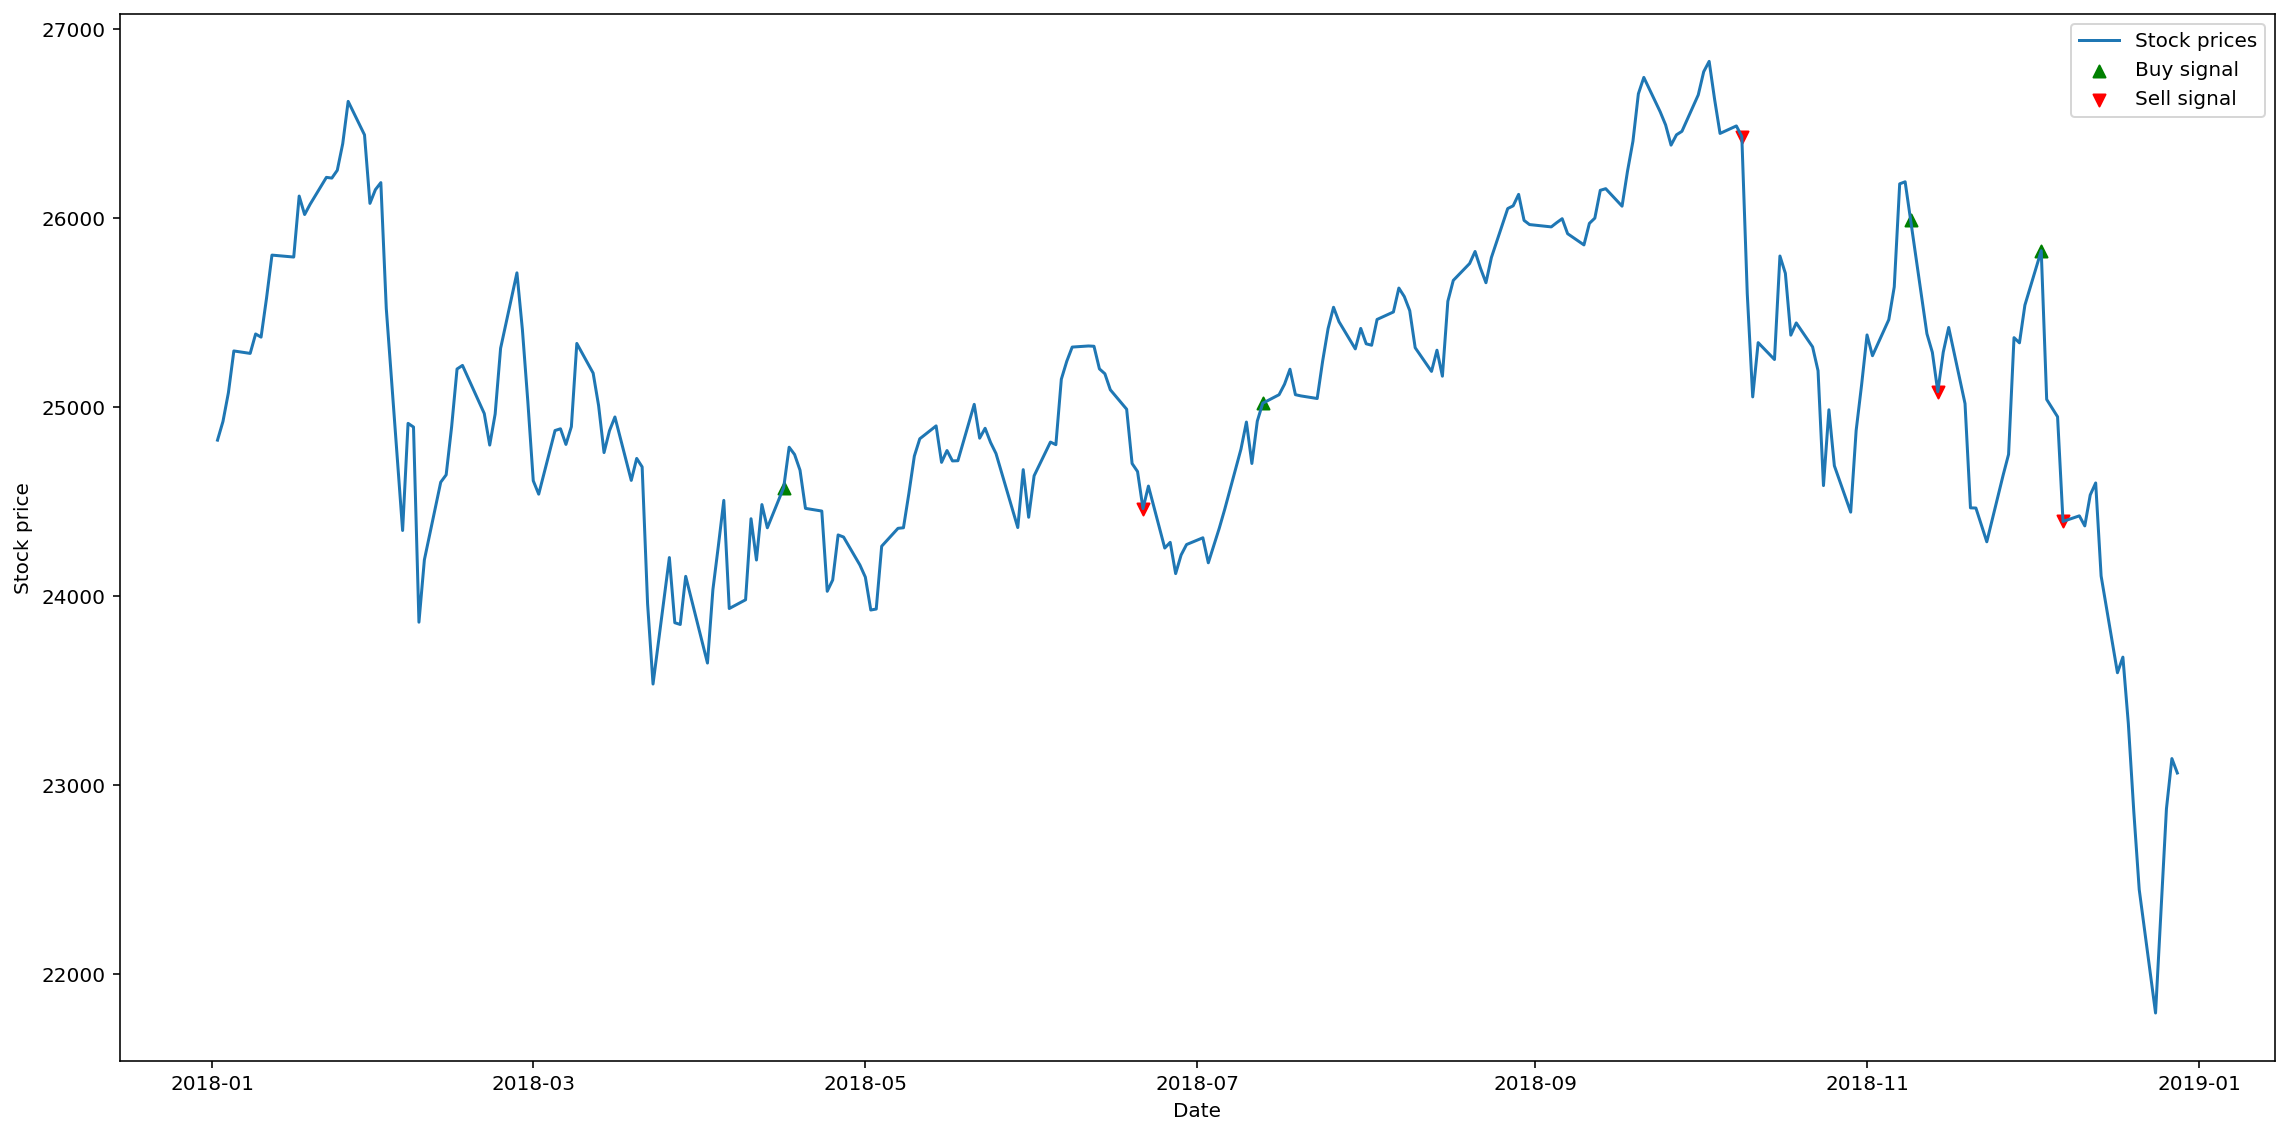

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2018-01-01', end='2018-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-28.8992	9.05555	-4.33105	5.54699
1  	731   	-29.7772	9.88243	-0.450044	4.21699
Net profit of buy and hold: 11.943875000000004
Running backtesting ...
Best individual: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
Best average net profit: 1.532806862832703
--------------------
Iteration 2 of 20 with best cv score: 1.532806862832703
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-28.8992	9.05555	-4.33105	5.54699
1  	731   	-29.7772	9.88243	-0.450044	4.21699
2  	693   	-27.8272	10.3778	1.83173  	3.90624
Net profi

9  	701   	-25.5343	14.201 	8.53597  	4.50324
10 	732   	-22.2851	16.1319	8.96287  	4.2224 
Net profit of buy and hold: 11.943875000000004
Running backtesting ...
Best individual: [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Best average net profit: 3.2625247290750865
--------------------
Iteration 11 of 20 with best cv score: 3.653755127056202
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-28.8992	9.05555	-4.33105	5.54699
1  	731   	-29.7772	9.88243	-0.450044	4.21699
2  	693   	-27.8272	10.3778	1.83173  	3.90624
3  	732   	-25.2055	11.0681	3.43547  	4.07956
4  	728   	-25.7693	11.0001	4.79983  	3.77697
5  	736   	-24.751 	14.0627	5.90213  	3.95358
6  	732   	-25.3437	13.4035	6.7393   	3.81549
7  	768   	-2

2  	693   	-27.8272	10.3778	1.83173  	3.90624
3  	732   	-25.2055	11.0681	3.43547  	4.07956
4  	728   	-25.7693	11.0001	4.79983  	3.77697
5  	736   	-24.751 	14.0627	5.90213  	3.95358
6  	732   	-25.3437	13.4035	6.7393   	3.81549
7  	768   	-25.916 	13.4035	7.44579  	3.76735
8  	718   	-24.5882	14.201 	8.01383  	3.99174
9  	701   	-25.5343	14.201 	8.53597  	4.50324
10 	732   	-22.2851	16.1319	8.96287  	4.2224 
11 	724   	-25.5343	16.1319	9.37402  	4.37597
12 	702   	-21.0649	16.1319	9.86773  	4.32161
13 	697   	-25.5343	16.1319	9.87275  	5.36953
14 	728   	-25.5343	16.1319	10.1415  	4.94011
15 	722   	-23.0713	16.1418	10.4229  	4.8322 
16 	691   	-25.5343	17.7641	11.0032  	5.02042
17 	734   	-25.0853	17.7641	11.333   	5.11192
Net profit of buy and hold: 11.943875000000004
Running backtesting ...
Best individual: [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1

In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2018-01-01', end='2018-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[243], [9, 36, 110], [13, 5]]
Net profit of strategy: 9.801200
Net profit of buy and hold: 4.599075
Percentage profit of strategy: 27.385303%
Percentage profit of buy and hold: 12.850168%
Number of buy signals: 4
Number of sell signals: 4


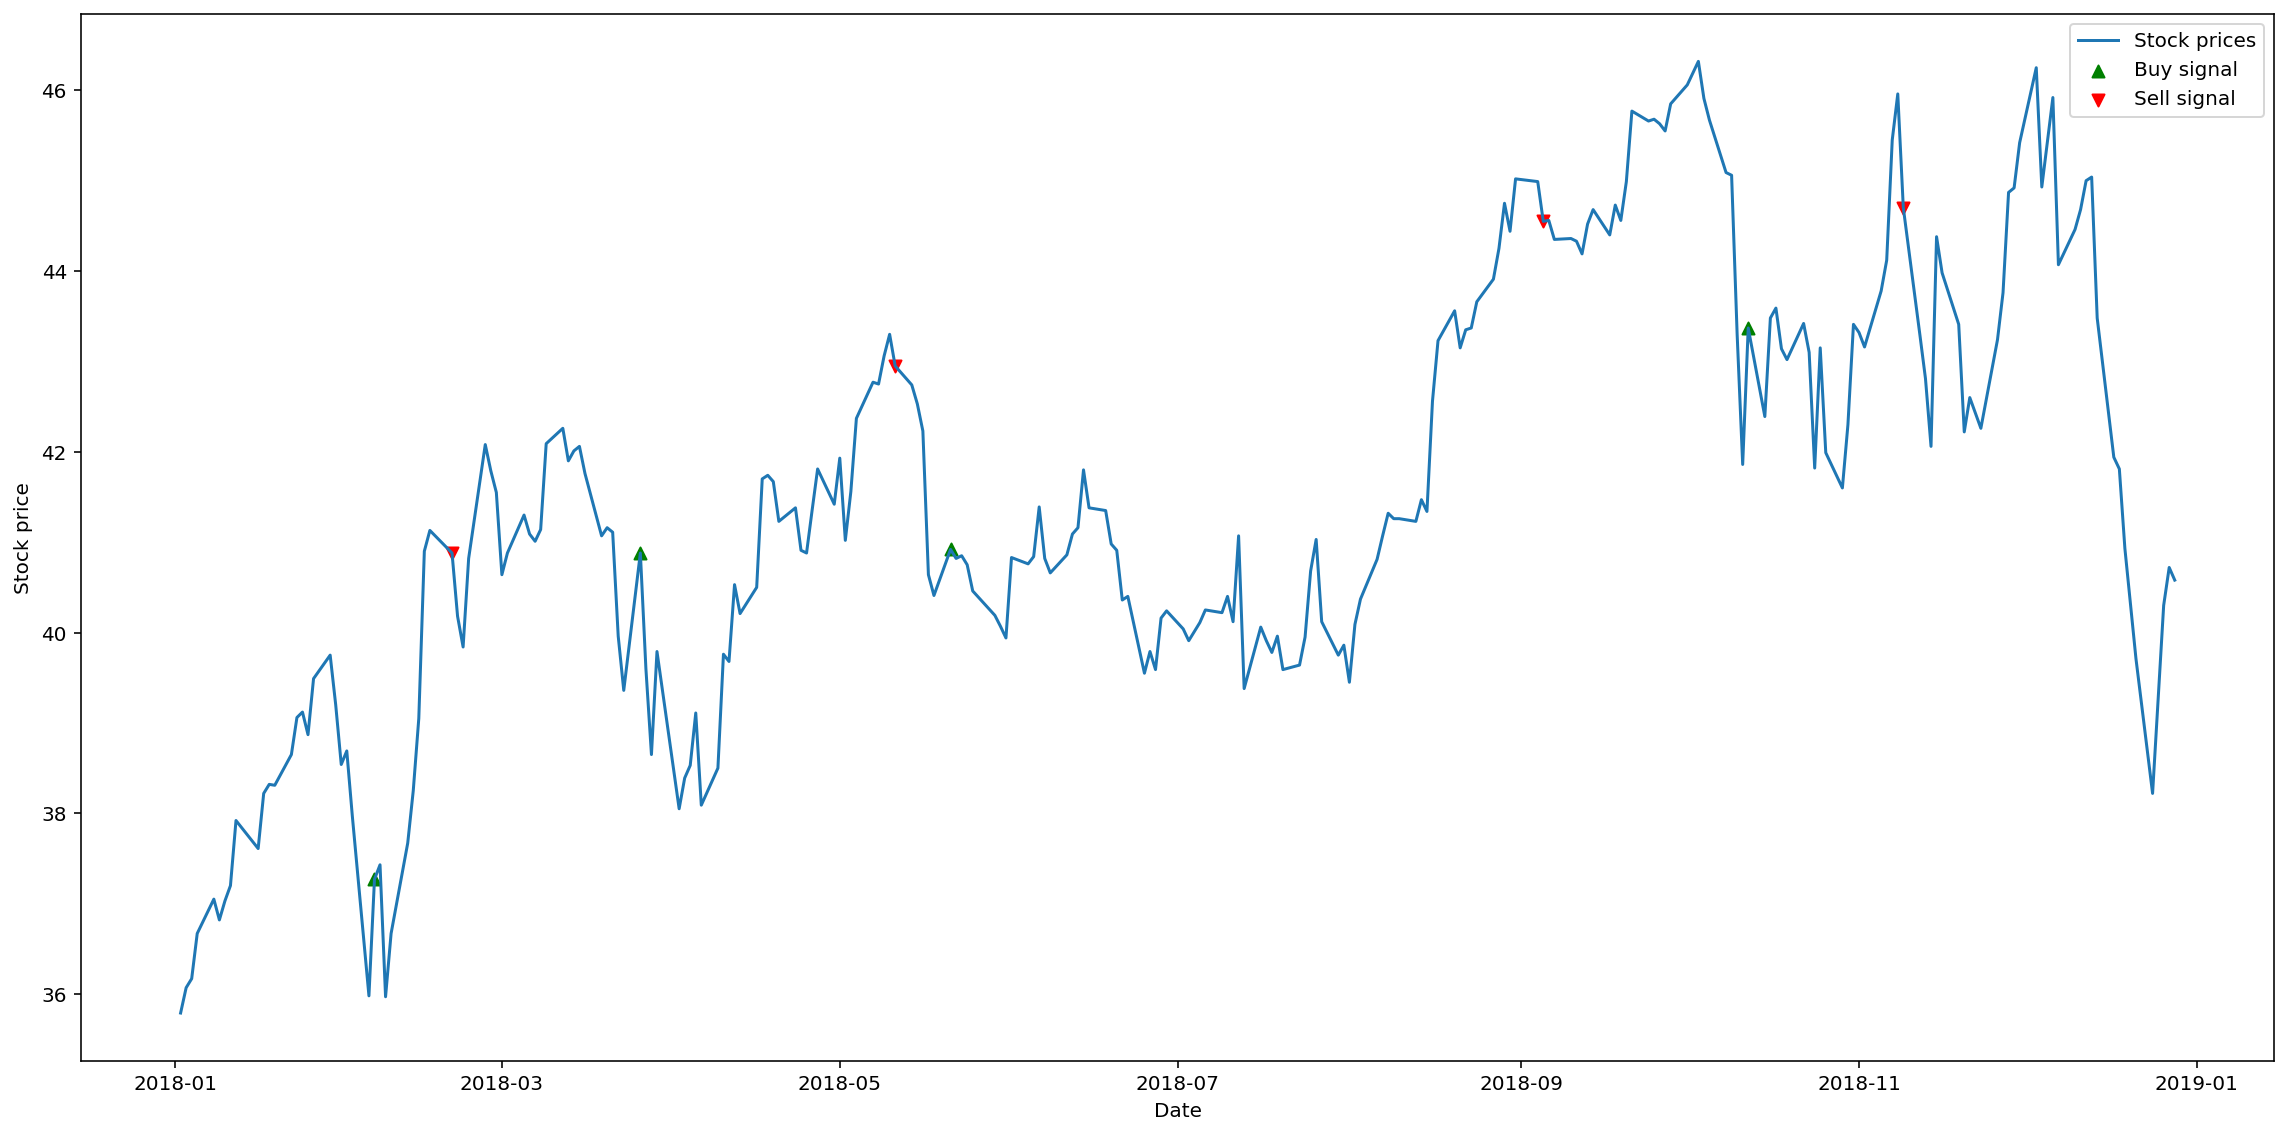

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2018-01-01', end='2018-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-54.0264	29.8766	-5.92543	15.0884
1  	731   	-53.743 	29.8766	3.83317 	10.6561
Net profit of buy and hold: 39.3793
Running backtesting ...
Best individual: [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Best average net profit: 6.339770074269772
--------------------
Iteration 2 of 20 with best cv score: 6.339770074269772
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-54.0264	29.8766	-5.92543	15.0884
1  	731   	-53.743 	29.8766	3.83317 	10.6561
2  	693   	-45.8022	33.4953	9.99997 	9.86663
Net profit of buy and h

Best individual: [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]
Best average net profit: 8.553168688590137
--------------------
Iteration 11 of 20 with best cv score: 9.534856186544381
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-54.0264	29.8766	-5.92543	15.0884
1  	731   	-53.743 	29.8766	3.83317 	10.6561
2  	693   	-45.8022	33.4953	9.99997 	9.86663
3  	732   	-48.1628	33.5756	13.9965 	9.61377
4  	728   	-45.3179	33.5756	16.8113 	10.1202
5  	736   	-46.5132	38.2653	18.0155 	10.763 
6  	732   	-46.6784	38.2653	20.2416 	10.63  
7  	768   	-48.6594	43.4119	21.1862 	10.7704
8  	718   	-45.8022	52.714 	23.0482 	10.996 
9  	701   	-42.3174	52.714 	24.9833 	10.527 
10 	732   	-44.9787	52.765 	25.9934 	11.232 
11 

9  	701   	-42.3174	52.714 	24.9833 	10.527 
10 	732   	-44.9787	52.765 	25.9934 	11.232 
11 	724   	-42.0781	52.765 	28.4468 	10.7732
12 	702   	-46.4767	52.8601	30.2593 	11.1636
13 	697   	-43.3128	53.3125	30.9132 	12.2569
14 	728   	-41.2591	56.1033	33.7023 	11.805 
15 	722   	-44.9787	53.442 	36.5823 	11.9628
16 	691   	-14.9994	53.442 	39.9255 	11.5201
17 	734   	-14.0785	55.2482	42.455  	11.83  
Net profit of buy and hold: 39.3793
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Best average net profit: 7.619607287470904
--------------------
Iteration 18 of 20 with best cv score: 11.289737737095301
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-54.0264	29.8766	-5.9

In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2018-01-01', end='2018-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[46], [4, 46, 94], [2, 3]]
Net profit of strategy: -20.574300
Net profit of buy and hold: -21.382025
Percentage profit of strategy: -22.149101%
Percentage profit of buy and hold: -23.018651%
Number of buy signals: 13
Number of sell signals: 13


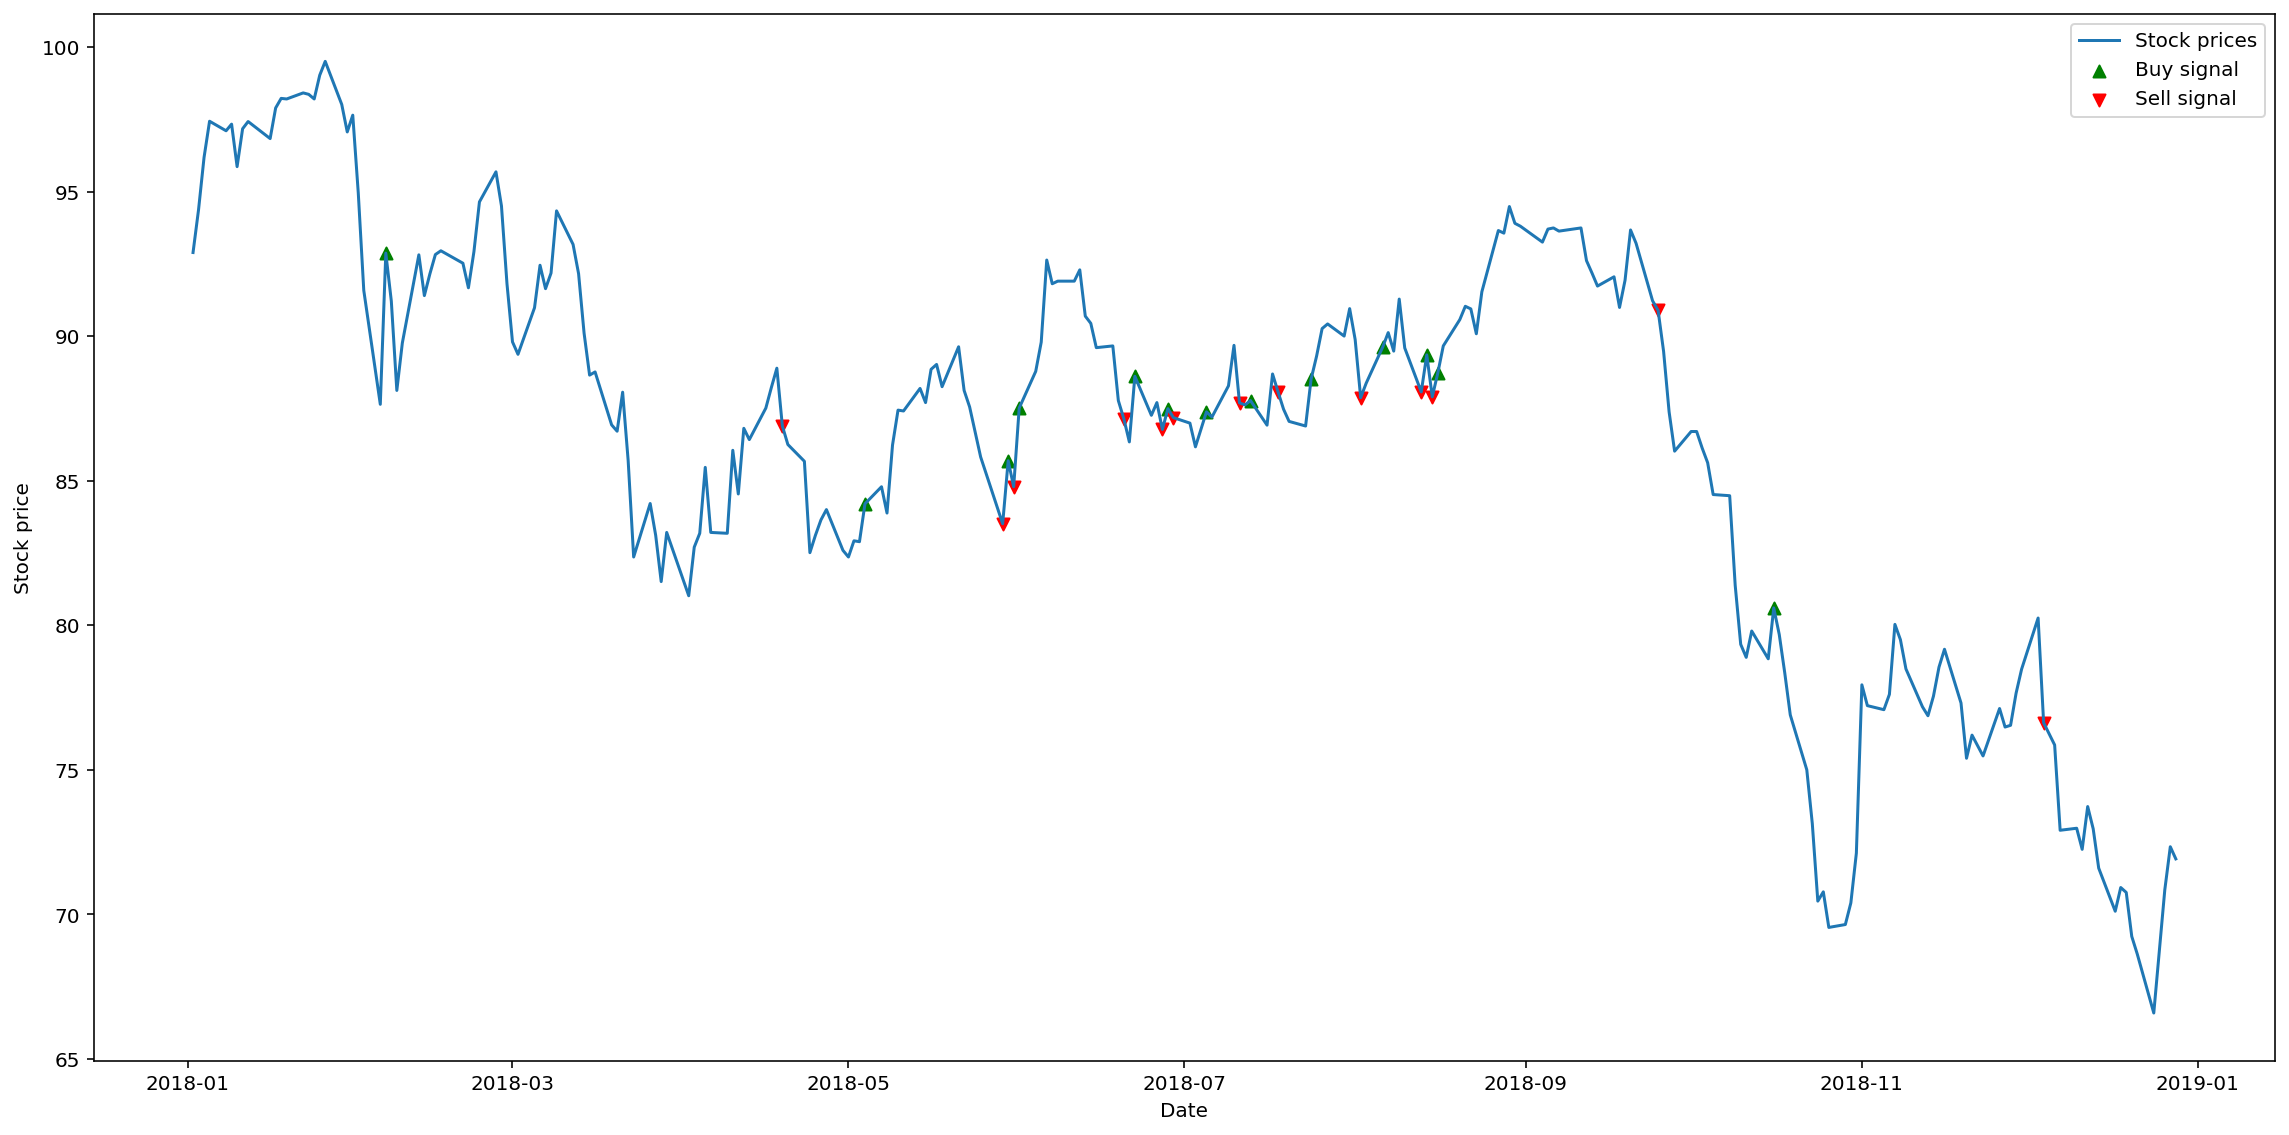

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2018-01-01', end='2018-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-52.8338	41.248	5.37999	14.7803
1  	731   	-50.5682	40.7941	15.1244	10.9067
Net profit of buy and hold: 44.969725000000004
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Best average net profit: 8.301649549695322
--------------------
Iteration 2 of 20 with best cv score: 8.301649549695322
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-52.8338	41.248	5.37999	14.7803
1  	731   	-50.5682	40.7941	15.1244	10.9067
2  	693   	-64.6942	44.1637	20.7376	10.6319
Net profit of buy and h

Best individual: [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Best average net profit: 8.020981943693023
--------------------
Iteration 11 of 20 with best cv score: 13.5654654881028
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-52.8338	41.248	5.37999	14.7803
1  	731   	-50.5682	40.7941	15.1244	10.9067
2  	693   	-64.6942	44.1637	20.7376	10.6319
3  	732   	-53.4997	44.1637	24.5399	10.3567
4  	728   	-50.9843	48.2201	27.7959	9.83181
5  	736   	-51.3759	48.2201	29.1804	10.9028
6  	732   	-51.7441	49.9789	31.0648	10.9343
7  	768   	-49.4948	48.4727	32.4815	10.2846
8  	718   	-33.9198	52.099 	33.7917	10.0198
9  	701   	-52.3559	52.4304	35.2205	10.3567
10 	732   	-52.51  	54.161 	35.8307	10.6039
11 	724   	-35.414

11 	724   	-35.4148	57.4461	36.8234	10.3189
12 	702   	-50.3563	57.0899	38.9622	9.63503
13 	697   	-37.361 	58.4975	39.6248	9.82646
14 	728   	-23.0328	58.4975	40.5782	10.2384
15 	722   	-29.0704	59.7438	41.108 	11.8051
16 	691   	-22.0461	59.3833	43.3644	9.98014
17 	734   	-49.9852	64.8929	44.0964	11.4024
Net profit of buy and hold: 44.969725000000004
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Best average net profit: 8.367850134614097
--------------------
Iteration 18 of 20 with best cv score: 13.5654654881028
Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-52.8338	41.248	5.37999	14.7803
1  	731   	-50.5682	40.7941	15.1244	10.9067
2  	693   	-64.6942	44.1637	20.7376

In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2018-01-01', end='2018-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[29, 52, 21], [15, 45, 104], [217], [26, 6]]
Net profit of strategy: -14.076000
Net profit of buy and hold: -8.697800
Percentage profit of strategy: -14.122605%
Percentage profit of buy and hold: -8.726598%
Number of buy signals: 7
Number of sell signals: 7


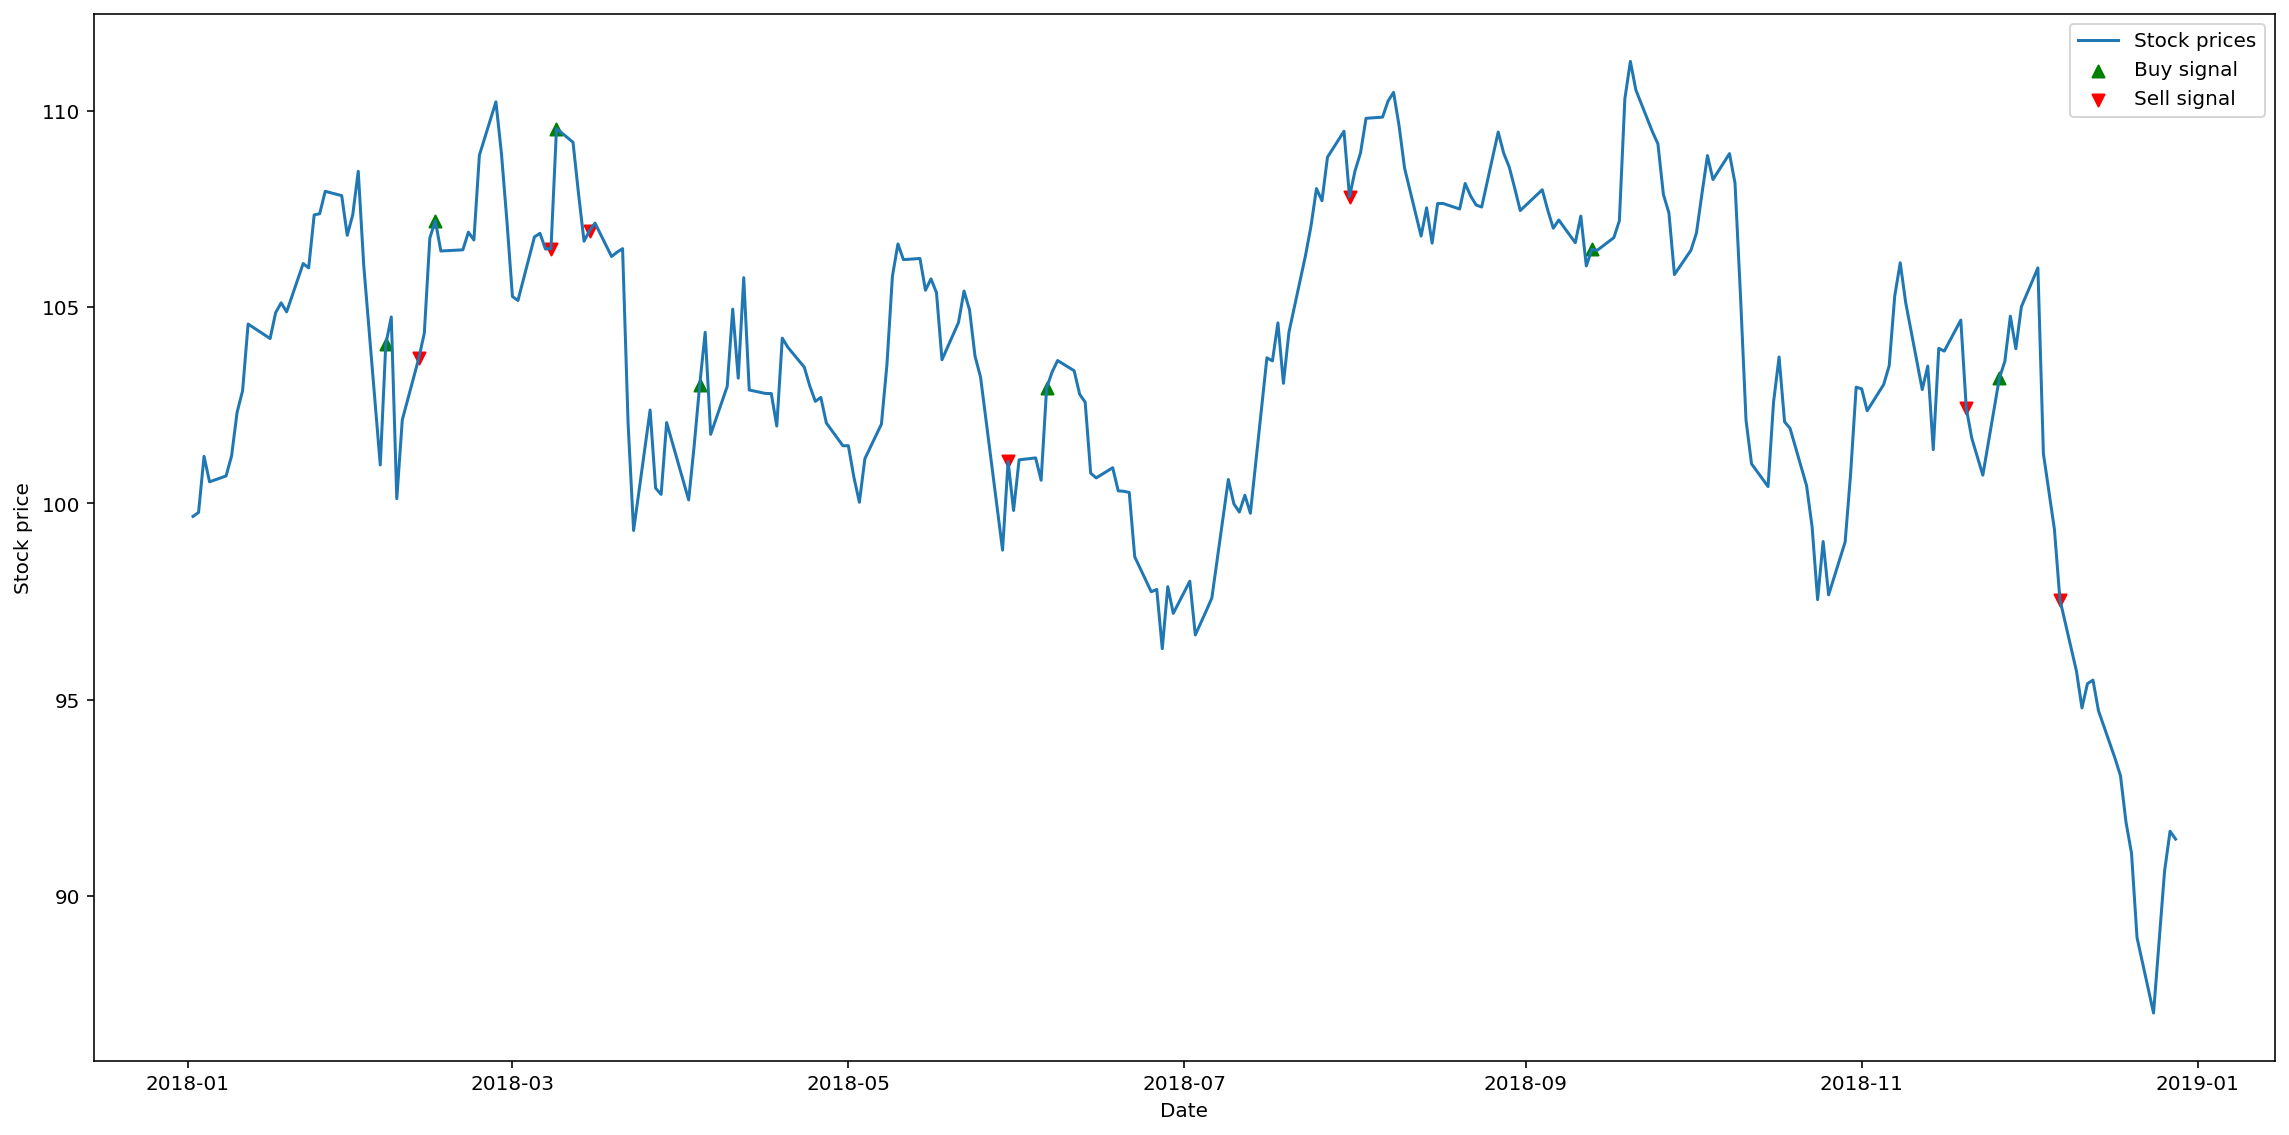

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2018-01-01', end='2018-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std   
0  	1000  	-45.3184	29.3243	-5.80483	9.6709
1  	731   	-43.7185	29.3243	0.323756	7.44923
Net profit of buy and hold: 40.25035
Running backtesting ...
Best individual: [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Best average net profit: 6.513491250162929
--------------------
Iteration 2 of 20 with best cv score: 6.513491250162929
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std   
0  	1000  	-45.3184	29.3243	-5.80483	9.6709
1  	731   	-43.7185	29.3243	0.323756	7.44923
2  	693   	-43.1602	26.4333	4.61555 	7.12332
Net profit of buy and hold

Best individual: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
Best average net profit: 9.460091562791598
--------------------
Iteration 11 of 20 with best cv score: 16.181629597745875
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std   
0  	1000  	-45.3184	29.3243	-5.80483	9.6709
1  	731   	-43.7185	29.3243	0.323756	7.44923
2  	693   	-43.1602	26.4333	4.61555 	7.12332
3  	732   	-44.4688	35.3188	7.11662 	7.84514
4  	728   	-42.4412	36.5033	10.4236 	8.10414
5  	736   	-40.7528	35.3188	12.9161 	8.7269 
6  	732   	-37.58  	37.1443	15.3162 	9.14867
7  	768   	-39.4173	39.5337	17.6786 	9.64111
8  	718   	-15.1987	41.8465	20.2236 	9.88774
9  	701   	-39.3041	42.4792	22.3655 	10.6721
10 	732   	-39.4173	42.4792	23.8084 	11.7352
11 	

9  	701   	-39.3041	42.4792	22.3655 	10.6721
10 	732   	-39.4173	42.4792	23.8084 	11.7352
11 	724   	-39.3041	46.4062	25.3344 	12.8738
12 	702   	-39.3041	46.4062	28.078  	13.1452
13 	697   	-39.3041	46.4062	28.5543 	15.006 
14 	728   	-39.3041	46.4062	29.1338 	15.7646
15 	722   	-39.3041	48.2182	31.3786 	15.7123
16 	691   	-40.6702	48.2182	34.177  	16.0246
17 	734   	-39.3041	48.2182	36.0706 	14.9661
Net profit of buy and hold: 40.25035
Running backtesting ...
Best individual: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Best average net profit: 7.143404391699577
--------------------
Iteration 18 of 20 with best cv score: 16.181629597745875
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std   
0  	1000  	-45.3184	29.3243	-5.8

In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2018-01-01', end='2018-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[12, 49, 125], [45, 7]]
Net profit of strategy: 17.826850
Net profit of buy and hold: 15.098125
Percentage profit of strategy: 21.582143%
Percentage profit of buy and hold: 18.278602%
Number of buy signals: 3
Number of sell signals: 3


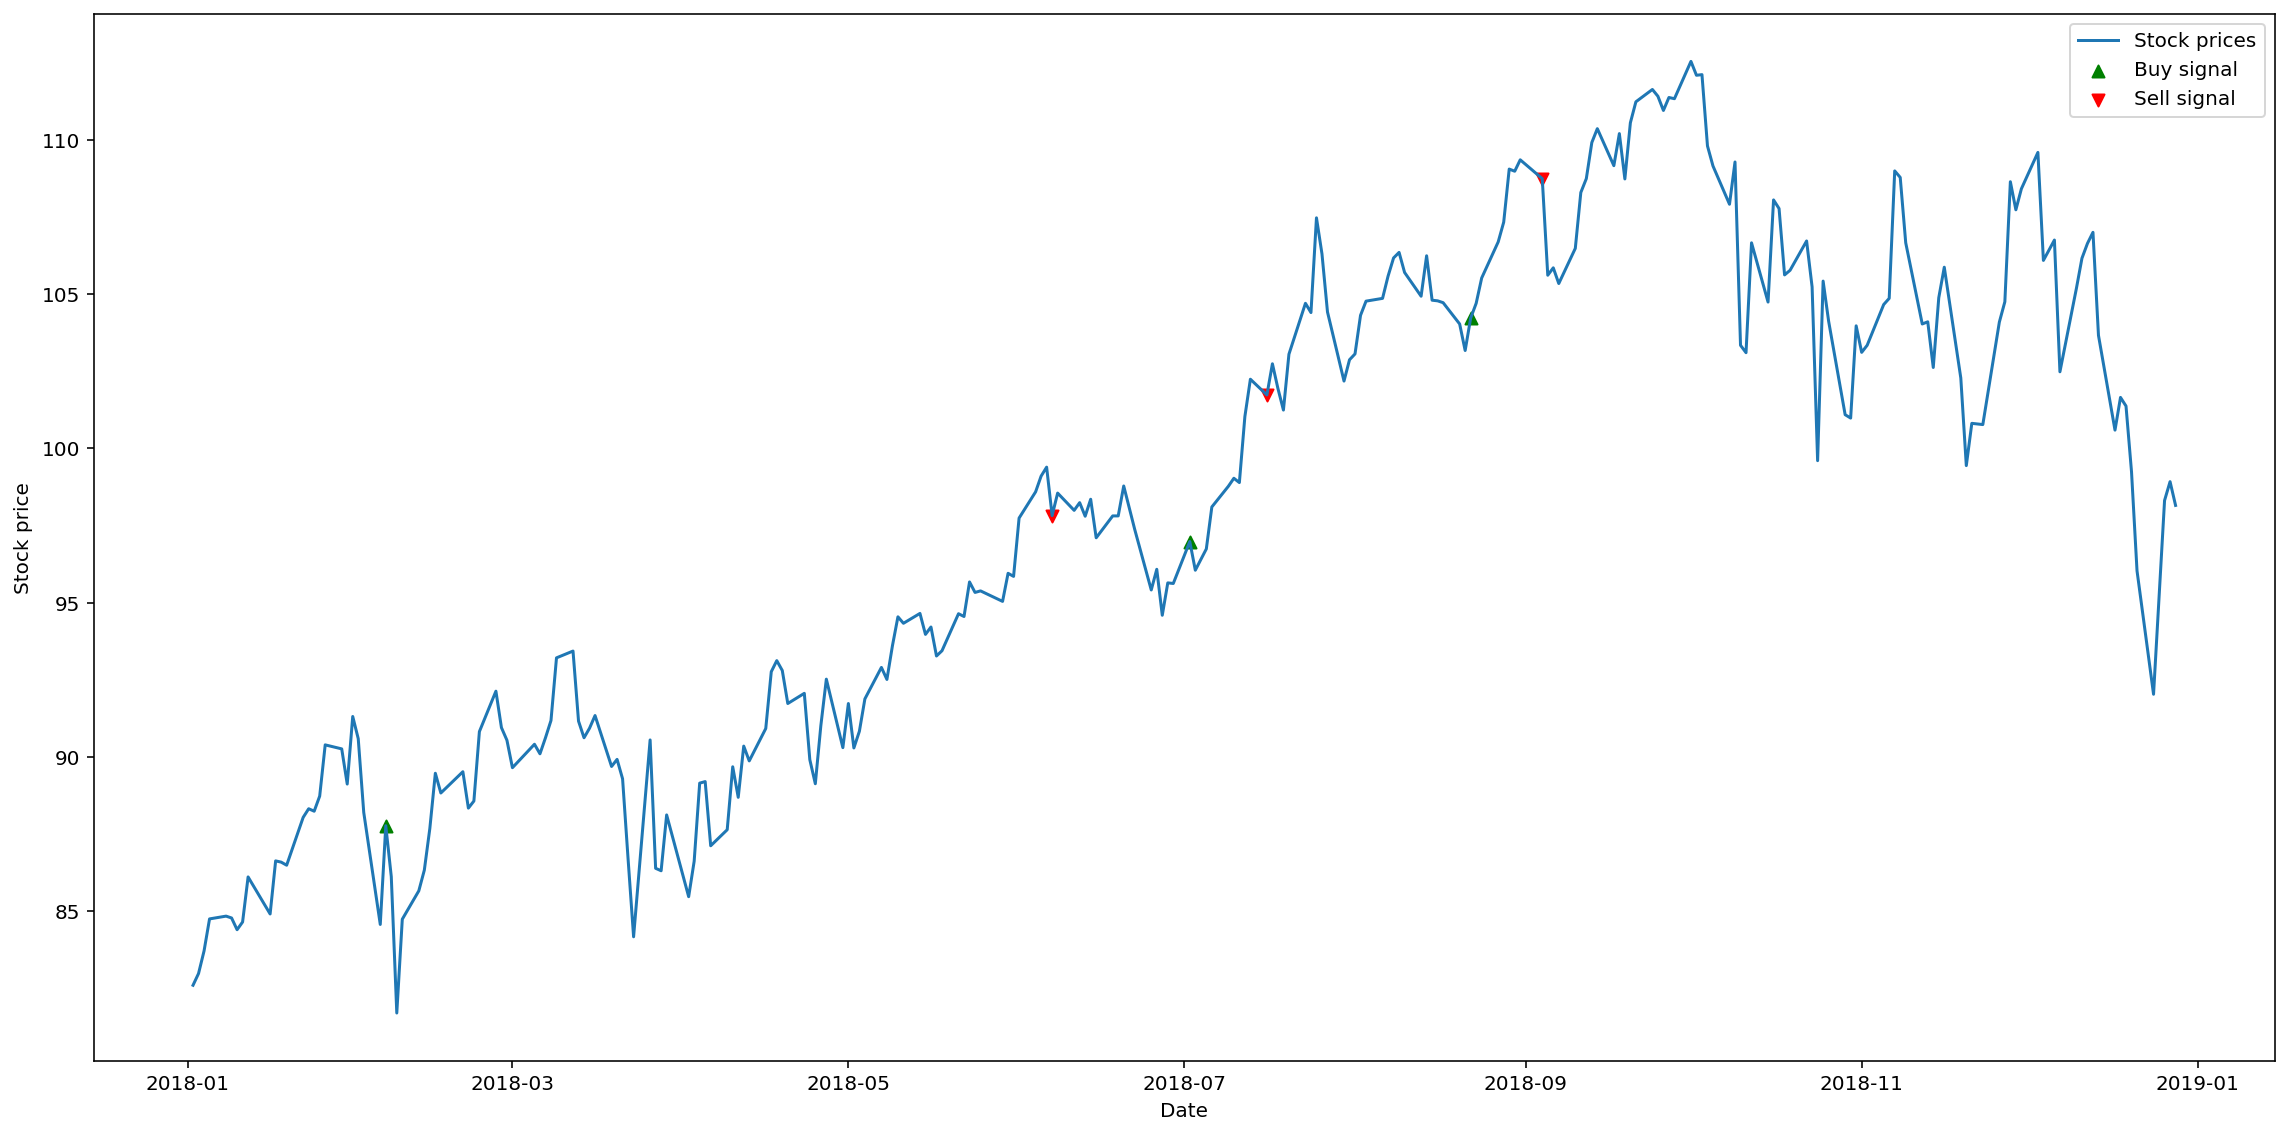

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2018-01-01', end='2018-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-47.4218	20.6588	-7.51498	9.98125
1  	731   	-53.8313	20.9993	-0.762687	8.4215 
Net profit of buy and hold: 16.548275000000004
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Best average net profit: 4.070426514027264
--------------------
Iteration 2 of 20 with best cv score: 4.070426514027264
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-47.4218	20.6588	-7.51498	9.98125
1  	731   	-53.8313	20.9993	-0.762687	8.4215 
2  	693   	-47.2494	23.7061	3.49021  	8.14995
Net profi

9  	701   	-31.6283	34.1221	17.5957  	7.59683
10 	732   	-43.9834	34.1221	17.8913  	8.36017
Net profit of buy and hold: 16.548275000000004
Running backtesting ...
Best individual: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Best average net profit: 2.7405530207469506
--------------------
Iteration 11 of 20 with best cv score: 4.070426514027264
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-47.4218	20.6588	-7.51498	9.98125
1  	731   	-53.8313	20.9993	-0.762687	8.4215 
2  	693   	-47.2494	23.7061	3.49021  	8.14995
3  	732   	-49.4926	25.4204	6.6884   	8.14063
4  	728   	-46.5794	28.6994	9.33275  	8.26554
5  	736   	-21.7751	28.6994	10.9494  	8.22716
6  	732   	-23.4992	29.5617	13.0611  	7.72211
7  	768   	-2

2  	693   	-47.2494	23.7061	3.49021  	8.14995
3  	732   	-49.4926	25.4204	6.6884   	8.14063
4  	728   	-46.5794	28.6994	9.33275  	8.26554
5  	736   	-21.7751	28.6994	10.9494  	8.22716
6  	732   	-23.4992	29.5617	13.0611  	7.72211
7  	768   	-26.1416	30.1579	14.3969  	8.15565
8  	718   	-22.3162	31.8165	15.8898  	7.54567
9  	701   	-31.6283	34.1221	17.5957  	7.59683
10 	732   	-43.9834	34.1221	17.8913  	8.36017
11 	724   	-33.8691	36.6138	18.603   	8.48162
12 	702   	-44.6672	36.6138	19.4206  	8.70524
13 	697   	-21.3906	37.1691	20.1382  	8.4001 
14 	728   	-43.1867	36.6138	20.6237  	9.01306
15 	722   	-43.7528	41.2737	20.8425  	9.83296
16 	691   	-21.0296	43.1848	22.7108  	9.04494
17 	734   	-43.3412	43.1848	23.7158  	9.71379
Net profit of buy and hold: 16.548275000000004
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0

In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2018-01-01', end='2018-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'RSI', 'BollingerBaender']
Active rules' parameters: [[239], [17, 194], [10, 115, 15], [26, 7]]
Net profit of strategy: 2.820125
Net profit of buy and hold: 10.035775
Percentage profit of strategy: 4.573670%
Percentage profit of buy and hold: 16.275989%
Number of buy signals: 7
Number of sell signals: 7


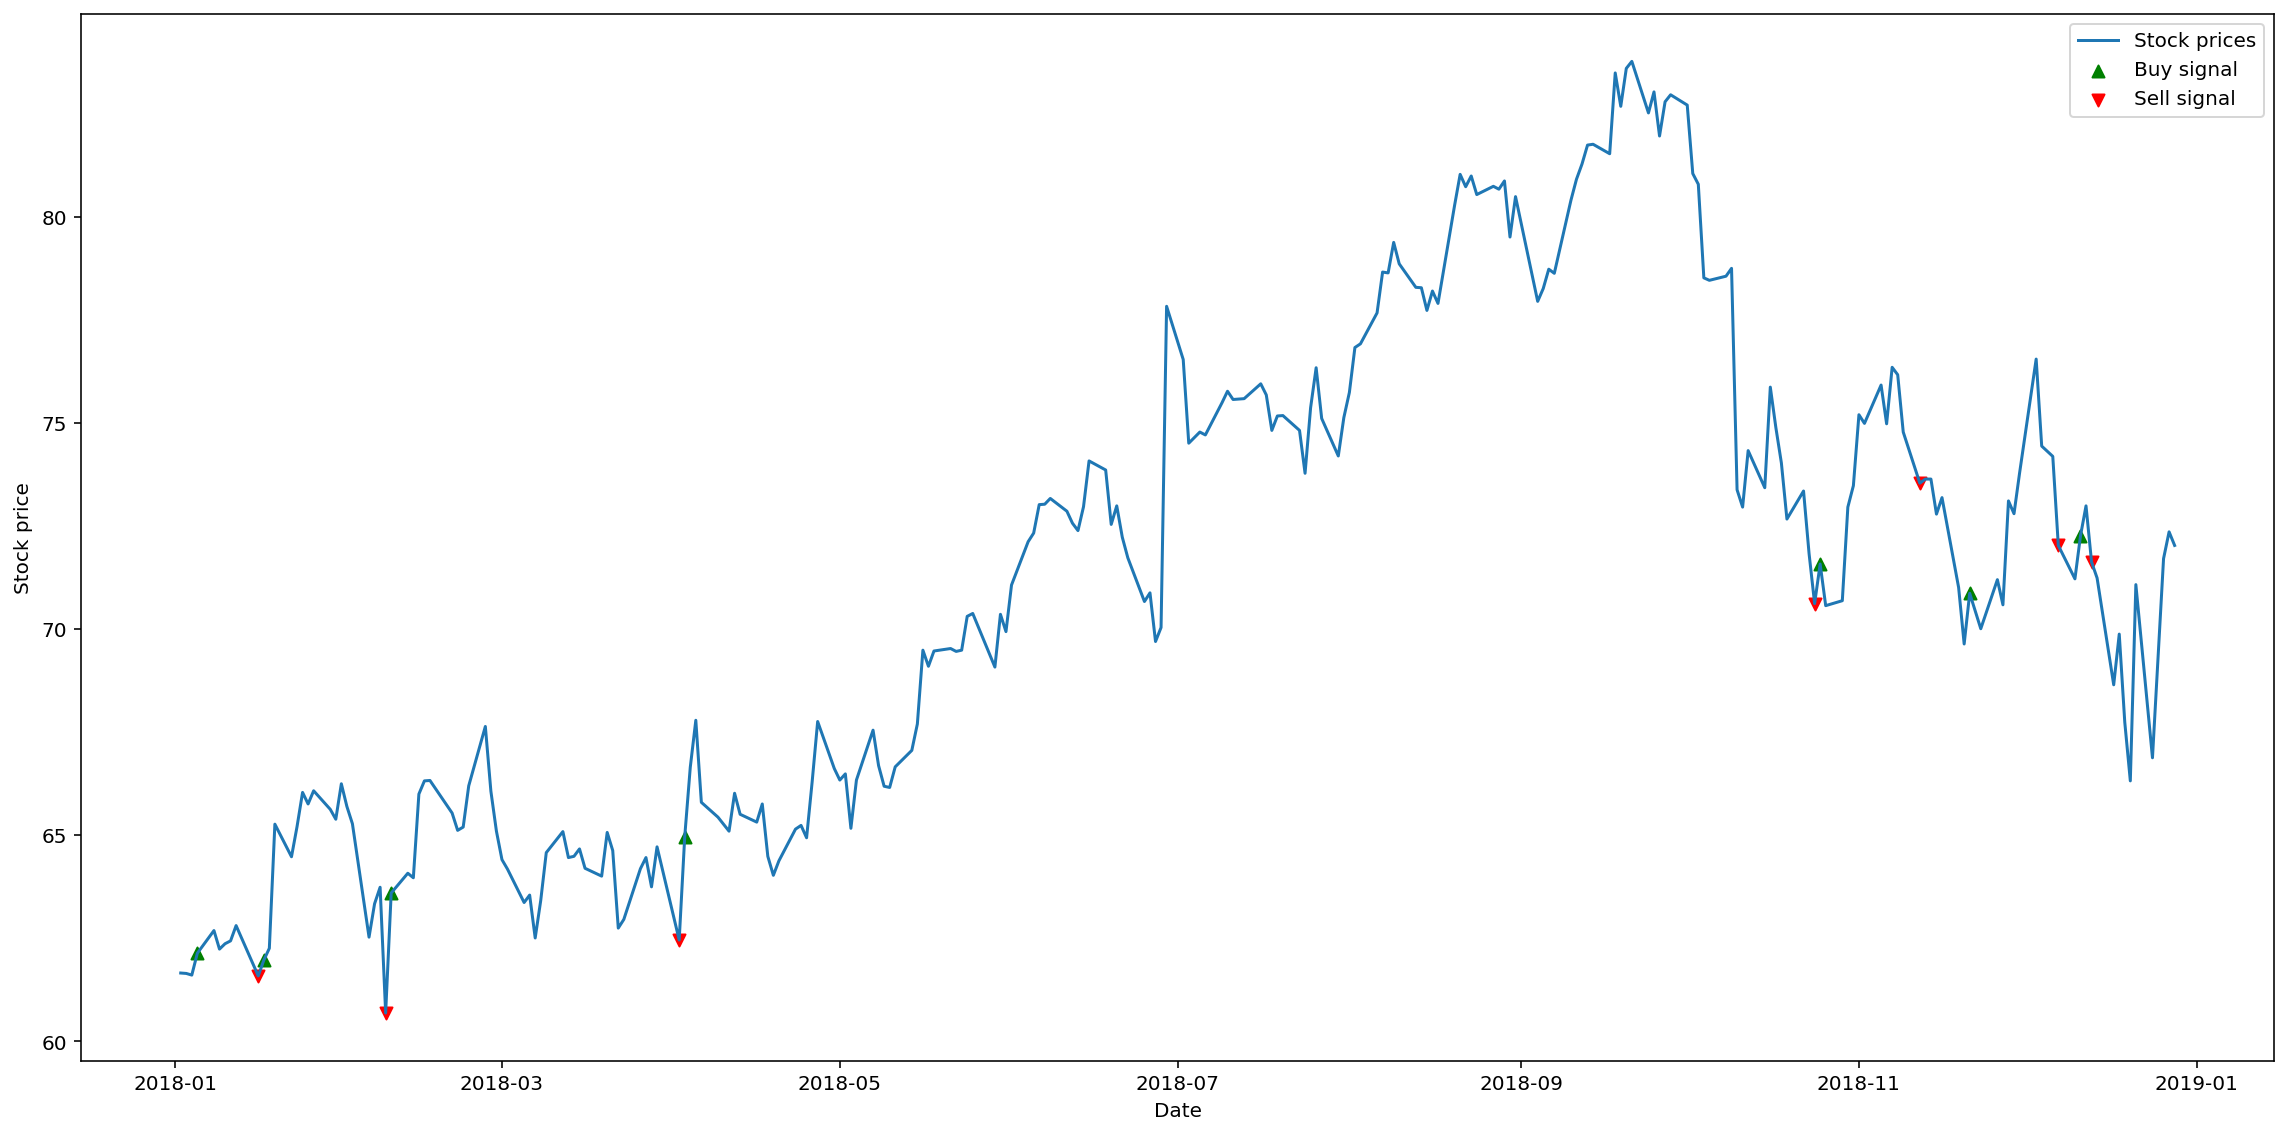

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2018-01-01', end='2018-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2015-01-01', end='2017-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 20 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-95.0717	103.869	-7.30699	25.4644
1  	731   	-88.6294	103.869	9.50672 	19.6786
Net profit of buy and hold: 118.46204999999999
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 35.25485031733488
--------------------
Iteration 2 of 20 with best cv score: 35.25485031733488
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-95.0717	103.869	-7.30699	25.4644
1  	731   	-88.6294	103.869	9.50672 	19.6786
2  	693   	-86.4511	103.869	20.2411 	19.7042
Net profit o

10 	732   	-86.353 	114.304	62.2925 	32.3942
Net profit of buy and hold: 118.46204999999999
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Best average net profit: 51.03565222512341
--------------------
Iteration 11 of 20 with best cv score: 51.03565222512341
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-95.0717	103.869	-7.30699	25.4644
1  	731   	-88.6294	103.869	9.50672 	19.6786
2  	693   	-86.4511	103.869	20.2411 	19.7042
3  	732   	-85.9295	103.869	28.1336 	20.2476
4  	728   	-52.3738	103.869	33.7901 	19.2347
5  	736   	-75.2944	103.869	38.5249 	21.276 
6  	732   	-90.6638	106.899	41.9151 	26.1122
7  	768   	-85.9295	109.207	46.3293 	28.0191
8  	718   	-85.9295	11

5  	736   	-75.2944	103.869	38.5249 	21.276 
6  	732   	-90.6638	106.899	41.9151 	26.1122
7  	768   	-85.9295	109.207	46.3293 	28.0191
8  	718   	-85.9295	114.304	51.9774 	30.0907
9  	701   	-85.9295	114.304	58.5849 	31.2592
10 	732   	-86.353 	114.304	62.2925 	32.3942
11 	724   	-85.9295	123.903	67.4314 	32.2174
12 	702   	-87.7551	123.589	72.0438 	37.0126
13 	697   	-90.6261	123.589	74.221  	39.5487
14 	728   	-87.6824	123.589	75.6401 	43.7174
15 	722   	-86.273 	123.73 	81.78   	44.4364
16 	691   	-85.9295	123.73 	90.5106 	41.9294
17 	734   	-85.9295	123.903	93.1727 	43.8162
Net profit of buy and hold: 118.46204999999999
Running backtesting ...
Best individual: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Best average net profit: 53.4068330978

In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2018-01-01', end='2018-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 49, 92], [61, 4]]
Net profit of strategy: 17.513750
Net profit of buy and hold: 26.082625
Percentage profit of strategy: 8.266272%
Percentage profit of buy and hold: 12.310674%
Number of buy signals: 1
Number of sell signals: 1


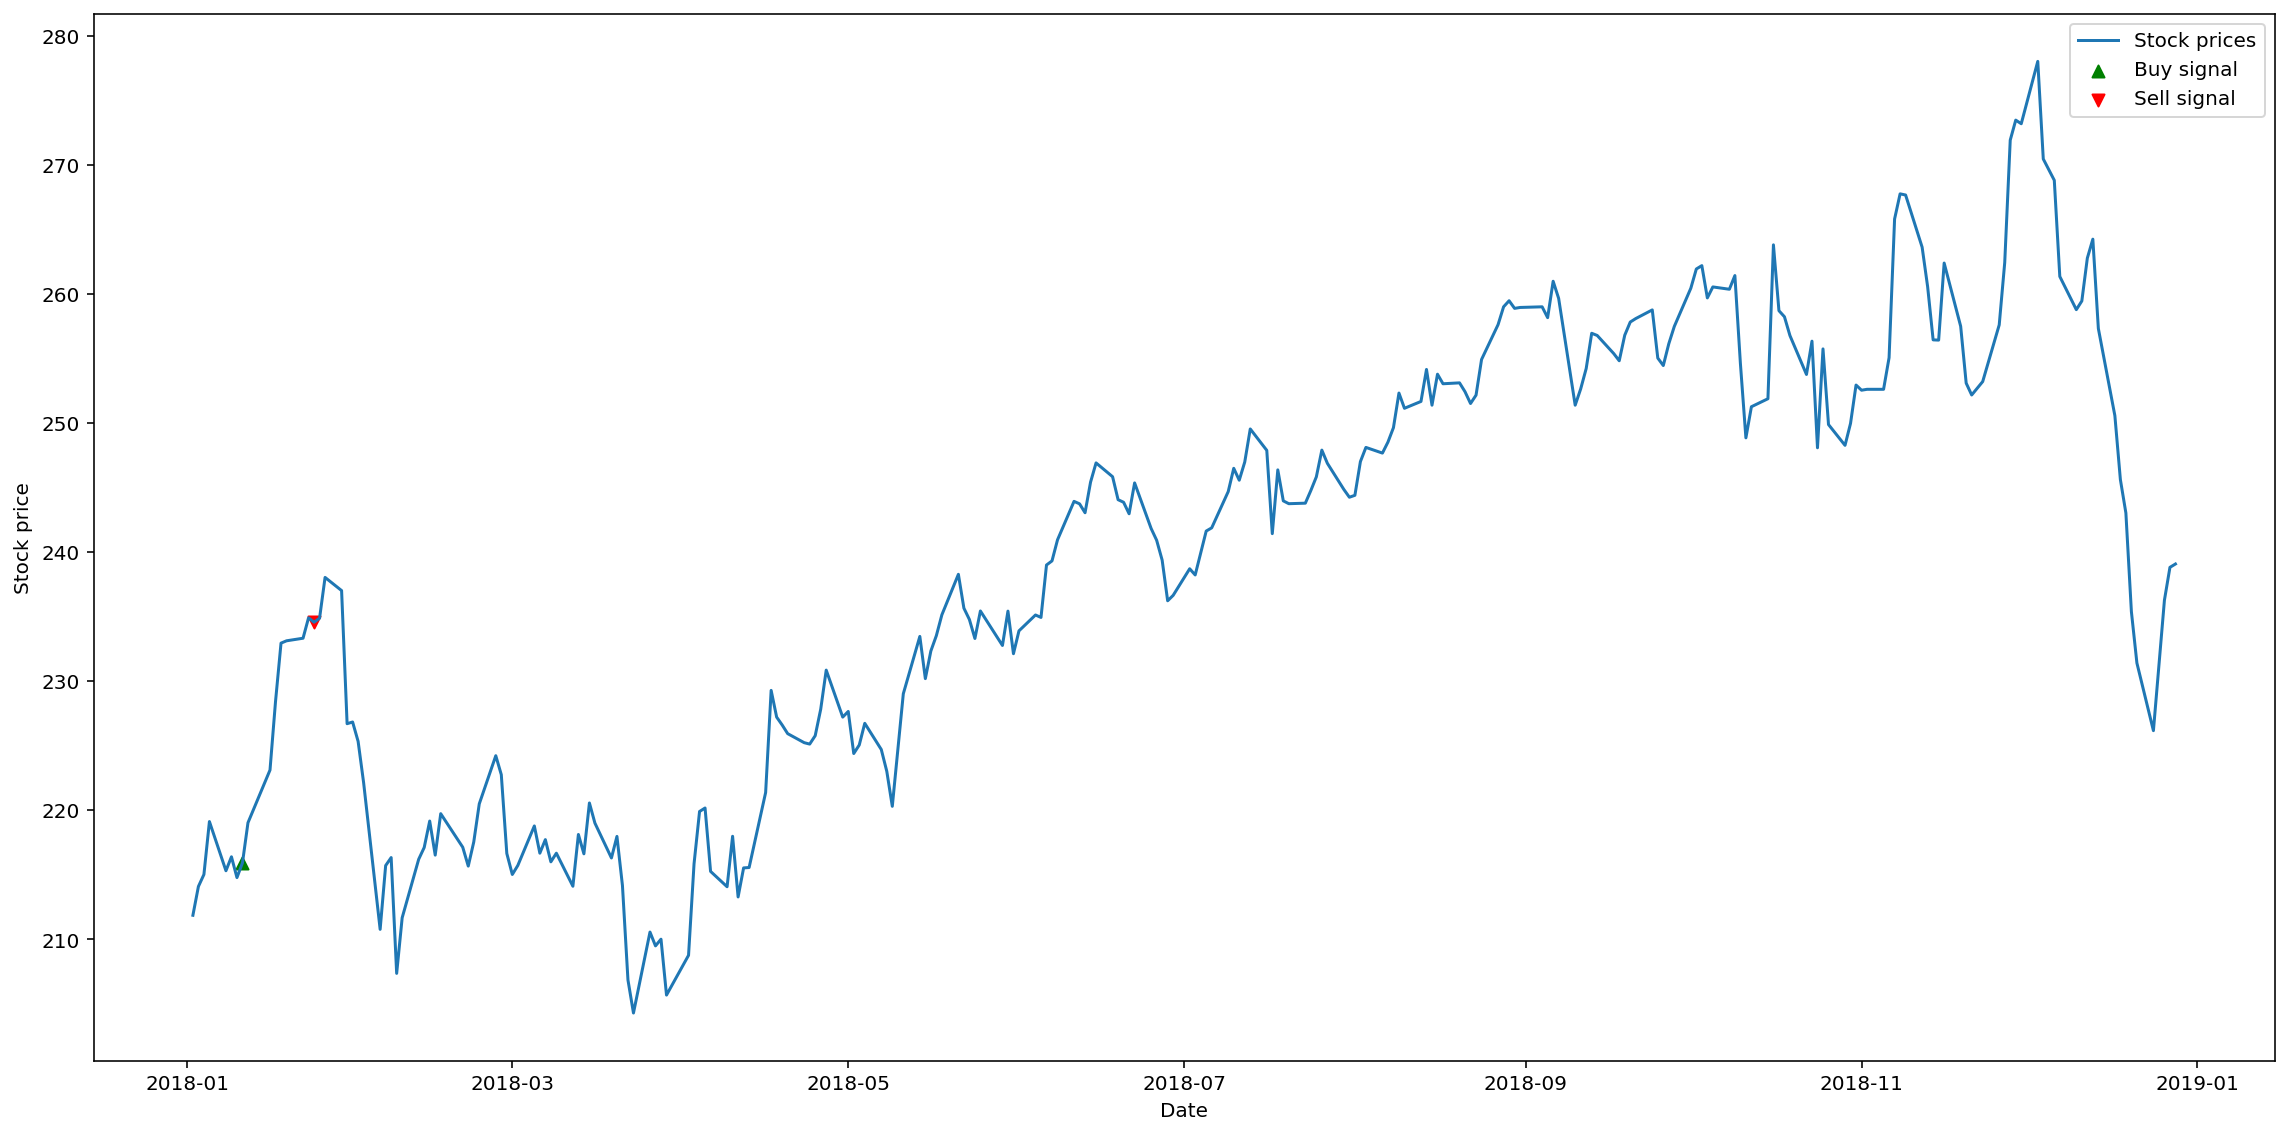

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2018-01-01', end='2018-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[-5.27102384794699, -18.833109198493815]","[6.495326508552241, 11.639727856552415]","[-10.742370081105449, -5.78564133373385]","[-11.498468345813501, -31.817018379850236]","[0.0, -56.22374355670103]","[5.671532846715291, 4.273114355231143]","[3.7354233226837654, -5.451078274760376]","[-6.227991057041597, -7.5786174669674455]","[27.385303157306474, 12.85016764459346]","[-22.1491010873074, -23.018651092690277]","[-14.122604595164226, -8.726597772649743]","[21.58214285714285, 18.27860169491527]","[4.57367012650028, 16.275989296140132]","[8.266271770425254, 12.31067399820645]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

0.5498651124962137

In [52]:
np.mean(bh_results)

-5.8432987307291375